ここに学習で必要なパラメータを定義する

In [1]:
# 表示用
from tqdm import tqdm
from tqdm import tnrange, tqdm_notebook

In [2]:
import numpy as np
import datetime
import os
import copy

# Parametor about Sensor
SensorNum=1 # Sensor number
#SensorAxis='AccX' # Axis

# Parametor about  " Sliding Window " 
WindowWidth =np.array([128,256,512,1024,2048,4096]) # Window Width
SlidingWidth =WindowWidth/4 #sliding window

# Parametor about Neural Network
AEDimention = 16

# Define Data Name
DATE= str( datetime.date.today() )+'/'
TITLE="Participants01_First_1/"
Label = ['LeftHand','RightHand','LeftLeg','Rightleg','West','Chest']

# Parametor about " Data Path"
DataPath = "/media/takeyama/Transfer/02_ActivityResearch/Paticipants01/01_First/20161018-105301/mem/"
StorePath = "/home/takeyama/Documents/"

if not os.path.exists(StorePath+TITLE+'dictionary/'): 
    os.makedirs(StorePath+TITLE+'dictionary/')
DictionaryDataPath=StorePath+TITLE+'dictionary/'

if not os.path.exists(StorePath+TITLE+DATE+'window/'): 
    os.makedirs(StorePath+TITLE+DATE+'window/')
WindowDataPath=StorePath+TITLE+DATE+'window/'

if not os.path.exists(StorePath+TITLE+DATE+'studyOutput/'): 
    os.makedirs(StorePath+TITLE+DATE+'studyOutput/')
StudyOutputPath=StorePath+TITLE+DATE+'studyOutput/'

if not os.path.exists(StorePath+TITLE+DATE+'parametor/'): 
    os.makedirs(StorePath+TITLE+DATE+'parametor/')
ParametorPath=StorePath+TITLE+DATE+'parametor/'

if not os.path.exists(StorePath+TITLE+DATE+'result/'): 
    os.makedirs(StorePath++TITLE+DATE+'result/')
ResultPath=StorePath+TITLE+DATE+'result/'

if not os.path.exists(StorePath+TITLE+DATE+'graph/'): 
    os.makedirs(StorePath+TITLE+DATE+'graph/')
GraphPath=StorePath+TITLE+DATE+'graph/'

**センサデータの読み込み**

In [3]:
# センサデータのcsvファイル名をリストに集約する関数
def SensorDataFileNameList(path):
    l = os.listdir(DataPath)
    FilePath =[]
    SensorName = []
    
    for n in range(len(l)):
        if (l[n][:4].find('mem-') != -1):
            FilePath.append(l[n])
            SensorName.append(l[n][4:15])
    
    return FilePath,SensorName

CSVを読み込んで，CSVの中身を辞書型で表現する．

In [4]:
def ImportCSV(csv_file,SensorName,mode='Round'):
    import pandas as pd
    '''
    ~Argument~
    csv_file -> ファイル名 
    mode Round -> 四捨五入
         Roundup -> 切り上げ
         Rounddown -> 切り捨て
    
    ~Conversion~
    Acc Data  [0.1mG]=>[G]
    Gyr Data  [0.01dps]=>[dps]   ...dps=degree per second
    '''
    # data dictionary 
    RawData={}   
    AccConversion = 0.1 * 0.001
    GyrConversion = 0.01
    
    # design dataframe and import csv
    data = pd.read_csv(csv_file)
    data.columns=[u'Type',u'Time',u'AccX',u'AccY',u'AccZ',u'GyrX',u'GyrY',u'GyrZ']
    data = data[ data['Type']=='ags']

    # convert numpy.darray 

    AccX=data.AccX.values*AccConversion
    AccY=data.AccY.values*AccConversion
    AccZ=data.AccZ.values*AccConversion
    
    GyrX=data.GyrX.values*GyrConversion
    GyrY=data.GyrY.values*GyrConversion
    GyrZ=data.GyrZ.values*GyrConversion

    # regist each raw data 
    RawData['AccX'] = AccX
    RawData['AccY'] = AccY
    RawData['AccZ'] = AccZ
    RawData['GyrX'] = GyrX
    RawData['GyrY'] = GyrY
    RawData['GyrZ'] = GyrZ
    RawData['Name'] = SensorName

    RawData['Time'] = data.Time.values

    return RawData

In [5]:
import processing
import window

Label = ['LeftHand','RightHand','LeftLeg','Rightleg','West','Chest']

DataFileNameList,SensorName=SensorDataFileNameList(DataPath)
l=[]
for i in range( len(DataFileNameList) ):
    l.append( ImportCSV(DataPath+DataFileNameList[i],Label[i]) )

**出力チェック**

In [6]:
l[0]

{'AccX': array([-1.0102, -0.9973, -0.9951, ..., -0.1794, -0.1789, -0.1792]),
 'AccY': array([ 0.0828,  0.0782,  0.0765, ...,  0.3201,  0.3221,  0.3238]),
 'AccZ': array([-0.2692, -0.269 , -0.2661, ...,  0.8967,  0.8938,  0.883 ]),
 'GyrX': array([ 82.15,  81.2 ,  80.26, ...,   0.39,   0.54,   0.6 ]),
 'GyrY': array([ 13.45,  13.8 ,  14.  , ...,   5.57,   6.14,   6.49]),
 'GyrZ': array([ 12.8 ,  12.84,  12.7 , ...,   1.38,   1.65,   1.96]),
 'Name': 'LeftHand',
 'Time': array([36290378, 36290379, 36290380, ..., 37394180, 37394181, 37394182])}

In [7]:
l[1]

{'AccX': array([-0.9539, -0.9524, -0.9473, ..., -0.1909, -0.2337, -0.2002]),
 'AccY': array([ 0.1487,  0.1496,  0.1555, ...,  0.103 ,  0.1623,  0.2256]),
 'AccZ': array([-0.1474, -0.1401, -0.1452, ...,  0.9062,  0.9697,  0.9928]),
 'GyrX': array([-25.06, -24.22, -23.33, ...,  -5.12,  -5.44,  -6.07]),
 'GyrY': array([ 31.23,  30.85,  30.3 , ...,  -4.62,  -7.02, -13.01]),
 'GyrZ': array([-9.67, -9.76, -9.65, ...,  3.3 ,  3.5 ,  7.44]),
 'Name': 'RightHand',
 'Time': array([36290413, 36290414, 36290415, ..., 37400598, 37400599, 37400600])}

In [8]:
l[2]

{'AccX': array([ 0.974 ,  0.9793,  0.9776, ..., -0.3304, -0.3338, -0.3377]),
 'AccY': array([-0.0664, -0.0639, -0.0654, ...,  0.6701,  0.664 ,  0.6625]),
 'AccZ': array([-0.2318, -0.2291, -0.2279, ...,  0.6841,  0.6787,  0.6878]),
 'GyrX': array([ 1.42,  1.44,  1.36, ...,  1.03,  1.32,  1.35]),
 'GyrY': array([-1.57, -1.62, -1.8 , ...,  6.48,  6.54,  6.54]),
 'GyrZ': array([ 0.6 ,  0.61,  0.61, ...,  6.14,  6.1 ,  5.9 ]),
 'Name': 'LeftLeg',
 'Time': array([36289454, 36289455, 36289456, ..., 37383543, 37383544, 37383545])}

In [9]:
l[3]

{'AccX': array([ 0.9239,  0.9266,  0.9291, ..., -0.3042, -0.3091, -0.3069]),
 'AccY': array([-0.1819, -0.1841, -0.1831, ...,  0.204 ,  0.2096,  0.2074]),
 'AccZ': array([-0.3983, -0.409 , -0.4095, ...,  0.8953,  0.8936,  0.8948]),
 'GyrX': array([-0.23, -0.11, -0.17, ...,  0.24,  0.13, -0.02]),
 'GyrY': array([-1.4 , -1.39, -1.51, ..., -1.13, -1.05, -1.22]),
 'GyrZ': array([-0.09, -0.08,  0.11, ...,  2.23,  2.3 ,  2.4 ]),
 'Name': 'Rightleg',
 'Time': array([36289502, 36289503, 36289504, ..., 37375672, 37375673, 37375674])}

In [10]:
l[4]

{'AccX': array([ 0.8437,  0.8496,  0.8493, ..., -0.0044, -0.0108, -0.0078]),
 'AccY': array([-0.0334, -0.0337, -0.0364, ...,  0.0795,  0.0849,  0.089 ]),
 'AccZ': array([-0.5486, -0.542 , -0.5413, ...,  0.9938,  0.9762,  0.9752]),
 'GyrX': array([-3.27, -3.26, -3.18, ..., -0.66, -0.6 , -0.81]),
 'GyrY': array([ 2.89,  2.78,  2.73, ...,  0.41,  0.45,  0.32]),
 'GyrZ': array([ 2.35,  2.15,  2.16, ..., -0.19, -0.09, -0.04]),
 'Name': 'West',
 'Time': array([36289542, 36289543, 36289544, ..., 37399101, 37399102, 37399103])}

読み込んだセンサデータの時系列を整理する．
→具体的には，センサデータのスタート時間とゴール時間を整える．


In [11]:
def MakeCommonSection(inputDataArray):
    # 共通区間のスタート時間、ゴール時間を求める
    # スタート時間を求める
    startTime = min(inputDataArray[0]['Time'])
    
    for i in range(len(inputDataArray)):
        if startTime < min(inputDataArray[i]['Time']):
            startTime = min(inputDataArray[i]['Time'])
    
    # ゴール時間を求める
    goalTime = max(inputDataArray[0]['Time'])
    
    for i in range(len(inputDataArray)):
        if goalTime > max(inputDataArray[i]['Time']):
            goalTime = max(inputDataArray[i]['Time'])

    # 共通区間のスタート時間のインデックス、ゴール時間のインデックスを探索する
    def CalcSearchIndexFromTime(data, keyTime):
        """
        data　辞書型
        keyTime data['Time']の中の探す値
        """
        count = 0
        for i in range(0, len(data['Time'])):
            if keyTime == data['Time'][i]:
                print str(keyTime)+' is much in the index  whose number is '+str(i)
                return i
            
    startIndex = np.array([])
    goalIndex = np.array([])
    for obj in inputDataArray:
        print 'start'
        startIndex = np.append(startIndex, CalcSearchIndexFromTime(obj, startTime) ).astype(int)
        print 'goal'
        goalIndex = np.append(goalIndex, CalcSearchIndexFromTime(obj, goalTime) ).astype(int)

    tmp={}
    comDataArray =[]
    key={}

    # センサデータすべて（時刻、加速度、角速度）に対して共通区間のみのデータを抽出
    for number,iDA in enumerate( inputDataArray ):

        tmp['AccX'] = copy.deepcopy( iDA['AccX'][startIndex[number]:goalIndex[number]] )
        tmp['AccY'] = copy.deepcopy( iDA['AccY'][startIndex[number]:goalIndex[number]] )
        tmp['AccZ'] = copy.deepcopy( iDA['AccZ'][startIndex[number]:goalIndex[number]] )
        tmp['GyrX'] = copy.deepcopy( iDA['GyrX'][startIndex[number]:goalIndex[number]] )
        tmp['GyrY'] = copy.deepcopy( iDA['GyrY'][startIndex[number]:goalIndex[number]] )
        tmp['GyrZ'] = copy.deepcopy( iDA['GyrZ'][startIndex[number]:goalIndex[number]] )
        tmp['Time'] = copy.deepcopy( iDA['Time'][startIndex[number]:goalIndex[number]] )
        tmp['Name'] = copy.deepcopy( iDA['Name'] )
        comDataArray.append(copy.deepcopy(tmp) )    
        key[ tmp['Name'] ] = number
       
    return key,comDataArray

In [12]:
TrimKey,TrimData = MakeCommonSection(l)

start
36290413 is much in the index  whose number is 35
goal
37368283 is much in the index  whose number is 1077905
start
36290413 is much in the index  whose number is 0
goal
37368283 is much in the index  whose number is 1077870
start
36290413 is much in the index  whose number is 959
goal
37368283 is much in the index  whose number is 1078829
start
36290413 is much in the index  whose number is 911
goal
37368283 is much in the index  whose number is 1078781
start
36290413 is much in the index  whose number is 871
goal
37368283 is much in the index  whose number is 1078741
start
36290413 is much in the index  whose number is 834
goal
37368283 is much in the index  whose number is 1078704


In [13]:
type( TrimData[0] )

dict

辞書型に変換したデータをnp.savez関数でnpz型に圧縮し，保存する

In [14]:
for i in range(6):
    np.savez(DictionaryDataPath+TrimData[i]['Name'],data=TrimData[i])

ライブラリをimportする

In [15]:
# FFT library
from scipy import fftpack
from scipy import signal

# Graph Plot
import matplotlib.pyplot as plt

# Generate WindowFrame Function
from mymodule import window

# timer
import time

%matplotlib inline

In [16]:
from keras.models import Sequential
from keras.datasets import cifar10
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import SGD, Adadelta, Adagrad, Adam, Adamax, RMSprop, Nadam
from keras.utils import np_utils
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils.visualize_util import model_to_dot, plot
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping

import matplotlib.image as mpimg


Using Theano backend.
Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5005)


**Phase1 計測データの取得**

ここで行うことは，学習に用いるnpzファイルを読み込む

In [17]:
'LeftHand' in Label

True

In [18]:
l = os.listdir(DictionaryDataPath)
print l

['West.npz', 'Rightleg.npz', 'Chest.npz', 'RightHand.npz', 'LeftHand.npz', 'LeftLeg.npz']


In [19]:
def LoadDataFromNPZ(Path,DataName):
    """
    Path 　　NPZファイルがあるパス
    DataName 名前，ここでは装着した部位を指す
    """
    Label = ['LeftHand','RightHand','LeftLeg','RightLeg','West','Chest']
    
    # check which DataName is wrong
    if not DataName in Label: return -1
    
    for i in range( len(Label) ):
        if DataName == Label[i]:
            return np.load(Path+DataName+'.npz')['data'][()]

**Phase2 window flame 作成 & Learning**

In [20]:
optimizers = [SGD, Adadelta, Adamax, Adam, Adagrad,  RMSprop, Nadam]
optimArray = ["SGD", "Adadelta","Adamax", "Adam", "Adagrad",  "RMSprop", "Nadam"]

今回は，テストとして加速度Ｘのデータを使って学習する
ウィンドウ幅，スライド幅は最小に定義したベクトルの値


In [21]:
def AutoEncoder(TrainWindow,TestWindow,dim,opt,cname,batchSize=32):
    input_img = Input(shape=( TrainWindow.shape[1] ,))
    encoded = Dense(dim, activation='tanh')(input_img)
    decoded = Dense( TrainWindow.shape[1] , activation='linear')(encoded)
    autoencoder = Model(input=input_img, output=decoded)
    encoder = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=opt, loss='mse')

    #plot(autoencoder,  to_file=StudyDataModelPicPath+SaveFileNameNet+'.png')
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    hist = autoencoder.fit(TrainWindow, TestWindow,
                    nb_epoch=50,
                    verbose=2,
                    batch_size=batchSize,
                    shuffle=True,
                    validation_data=(TrainWindow, TestWindow),
                    callbacks=[early_stopping])
    time.sleep(0.1)

    encoded_imgs = encoder.predict(TrainWindow,batch_size=batchSize,verbose=1)
    decoded_imgs = decoder.predict(encoded_imgs,batch_size=batchSize,verbose=1)

    np.savez(StudyOutputPath+cname+'_Encoded',data=encoded_imgs)
    np.savez(StudyOutputPath+cname+'_Decoded',data=decoded_imgs)

    # save model and wights
    json_string = encoder.to_json()
    open(StudyOutputPath+cname+'_Encoded'+'.json', 'w').write(json_string)
    encoder.save_weights(ParametorPath+cname+'Encode_weights.h5',overwrite=True)

    json_string = decoder.to_json()
    open(StudyOutputPath+cname+'_Decoded'+'.json', 'w').write(json_string)
    decoder.save_weights(ParametorPath+cname+'Decord_weights.h5',overwrite=True)

    json_string = autoencoder.to_json()
    open(StudyOutputPath+cname+'_Net'+'.json', 'w').write(json_string)
    autoencoder.save_weights(ParametorPath+cname+'Net_weights.h5',overwrite=True)

    # plot loss
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    nb_epoch = len(loss)
    plt.plot(range(nb_epoch), loss, marker='.', label='loss')
    plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
    plt.legend(loc='best', fontsize=10)
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig(ResultPath+cname+'.png')
    plt.show()

 18%|█▊        | 1553/8419 [00:00<00:00, 15520.39it/s]

AccX is registed now
Build Complete
Source shape is(1077870,)
window frames num =16839
offset=46


100%|██████████| 8419/8419 [00:05<00:00, 1409.68it/s]


hiden node = 16
_dim=0016_Win=0128_Sld=0032_SGD
Train on 8420 samples, validate on 8420 samples
Epoch 1/50
0s - loss: 0.6136 - val_loss: 0.4116
Epoch 2/50
0s - loss: 0.2745 - val_loss: 0.1685
Epoch 3/50
0s - loss: 0.1150 - val_loss: 0.0772
Epoch 4/50
0s - loss: 0.0593 - val_loss: 0.0465
Epoch 5/50
0s - loss: 0.0401 - val_loss: 0.0351
Epoch 6/50
0s - loss: 0.0321 - val_loss: 0.0295
Epoch 7/50
0s - loss: 0.0275 - val_loss: 0.0258
Epoch 8/50
0s - loss: 0.0244 - val_loss: 0.0232
Epoch 9/50
0s - loss: 0.0221 - val_loss: 0.0212
Epoch 10/50
0s - loss: 0.0204 - val_loss: 0.0197
Epoch 11/50
0s - loss: 0.0190 - val_loss: 0.0184
Epoch 12/50
0s - loss: 0.0179 - val_loss: 0.0174
Epoch 13/50
0s - loss: 0.0170 - val_loss: 0.0166
Epoch 14/50
0s - loss: 0.0162 - val_loss: 0.0159
Epoch 15/50
0s - loss: 0.0155 - val_loss: 0.0152
Epoch 16/50
0s - loss: 0.0149 - val_loss: 0.0147
Epoch 17/50
0s - loss: 0.0144 - val_loss: 0.0142
Epoch 18/50
0s - loss: 0.0139 - val_loss: 0.0137
Epoch 19/50
0s - loss: 0.0135 -

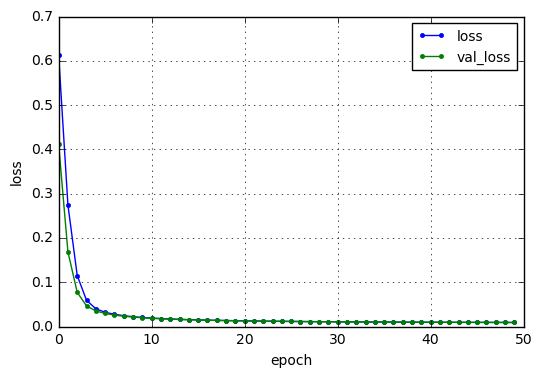

hiden node = 16
_dim=0016_Win=0128_Sld=0032_Adadelta
Train on 8420 samples, validate on 8420 samples
Epoch 1/50
0s - loss: 0.1583 - val_loss: 0.0159
Epoch 2/50
0s - loss: 0.0112 - val_loss: 0.0090
Epoch 3/50
0s - loss: 0.0088 - val_loss: 0.0079
Epoch 4/50
0s - loss: 0.0080 - val_loss: 0.0072
Epoch 5/50
0s - loss: 0.0073 - val_loss: 0.0065
Epoch 6/50
0s - loss: 0.0068 - val_loss: 0.0059
Epoch 7/50
0s - loss: 0.0063 - val_loss: 0.0055
Epoch 8/50
0s - loss: 0.0059 - val_loss: 0.0051
Epoch 9/50
0s - loss: 0.0056 - val_loss: 0.0147
Epoch 10/50
0s - loss: 0.0053 - val_loss: 0.0043
Epoch 11/50
0s - loss: 0.0050 - val_loss: 0.0041
Epoch 12/50
0s - loss: 0.0051 - val_loss: 0.0055
Epoch 13/50
0s - loss: 0.0047 - val_loss: 0.0039
Epoch 14/50
0s - loss: 0.0050 - val_loss: 0.0042
Epoch 15/50
0s - loss: 0.0050 - val_loss: 0.0055
Epoch 16/50
0s - loss: 0.0047 - val_loss: 0.0060
Epoch 17/50
0s - loss: 0.0046 - val_loss: 0.0035
Epoch 18/50
0s - loss: 0.0044 - val_loss: 0.0231
Epoch 19/50
0s - loss: 0.0

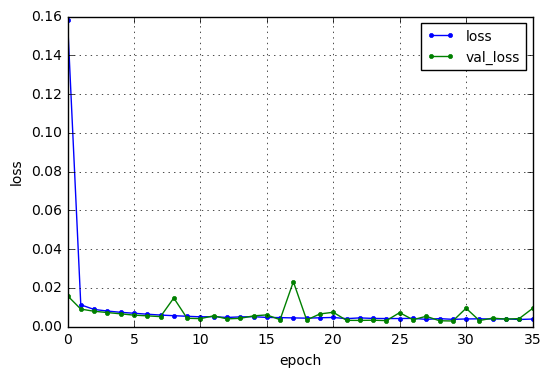

hiden node = 16
_dim=0016_Win=0128_Sld=0032_Adamax
Train on 8420 samples, validate on 8420 samples
Epoch 1/50
0s - loss: 0.0948 - val_loss: 0.0119
Epoch 2/50
0s - loss: 0.0103 - val_loss: 0.0094
Epoch 3/50
0s - loss: 0.0088 - val_loss: 0.0083
Epoch 4/50
0s - loss: 0.0080 - val_loss: 0.0075
Epoch 5/50
0s - loss: 0.0073 - val_loss: 0.0069
Epoch 6/50
0s - loss: 0.0066 - val_loss: 0.0062
Epoch 7/50
0s - loss: 0.0058 - val_loss: 0.0052
Epoch 8/50
0s - loss: 0.0050 - val_loss: 0.0047
Epoch 9/50
0s - loss: 0.0044 - val_loss: 0.0044
Epoch 10/50
0s - loss: 0.0040 - val_loss: 0.0036
Epoch 11/50
0s - loss: 0.0036 - val_loss: 0.0033
Epoch 12/50
0s - loss: 0.0033 - val_loss: 0.0036
Epoch 13/50
0s - loss: 0.0030 - val_loss: 0.0029
Epoch 14/50
0s - loss: 0.0028 - val_loss: 0.0027
Epoch 15/50
0s - loss: 0.0027 - val_loss: 0.0025
Epoch 16/50
0s - loss: 0.0024 - val_loss: 0.0021
Epoch 17/50
0s - loss: 0.0023 - val_loss: 0.0025
Epoch 18/50
0s - loss: 0.0021 - val_loss: 0.0020
Epoch 19/50
0s - loss: 0.001

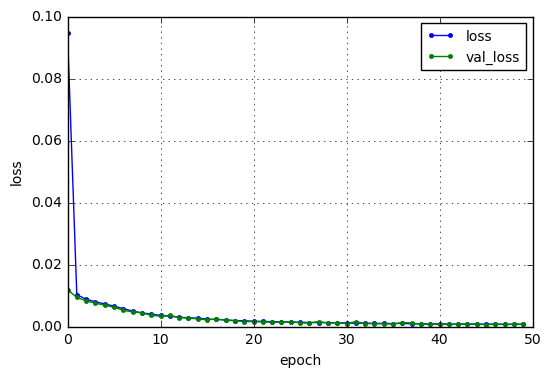

hiden node = 16
_dim=0016_Win=0128_Sld=0032_Adam
Train on 8420 samples, validate on 8420 samples
Epoch 1/50
0s - loss: 0.0992 - val_loss: 0.0109
Epoch 2/50
0s - loss: 0.0092 - val_loss: 0.0081
Epoch 3/50
0s - loss: 0.0077 - val_loss: 0.0072
Epoch 4/50
0s - loss: 0.0067 - val_loss: 0.0060
Epoch 5/50
0s - loss: 0.0058 - val_loss: 0.0066
Epoch 6/50
0s - loss: 0.0050 - val_loss: 0.0045
Epoch 7/50
0s - loss: 0.0045 - val_loss: 0.0041
Epoch 8/50
0s - loss: 0.0042 - val_loss: 0.0069
Epoch 9/50
0s - loss: 0.0037 - val_loss: 0.0035
Epoch 10/50
0s - loss: 0.0034 - val_loss: 0.0033
Epoch 11/50
0s - loss: 0.0032 - val_loss: 0.0031
Epoch 12/50
0s - loss: 0.0030 - val_loss: 0.0026
Epoch 13/50
0s - loss: 0.0029 - val_loss: 0.0025
Epoch 14/50
0s - loss: 0.0025 - val_loss: 0.0022
Epoch 15/50
0s - loss: 0.0024 - val_loss: 0.0020
Epoch 16/50
0s - loss: 0.0024 - val_loss: 0.0023
Epoch 17/50
0s - loss: 0.0020 - val_loss: 0.0018
Epoch 18/50
0s - loss: 0.0020 - val_loss: 0.0016
Epoch 19/50
0s - loss: 0.0018 

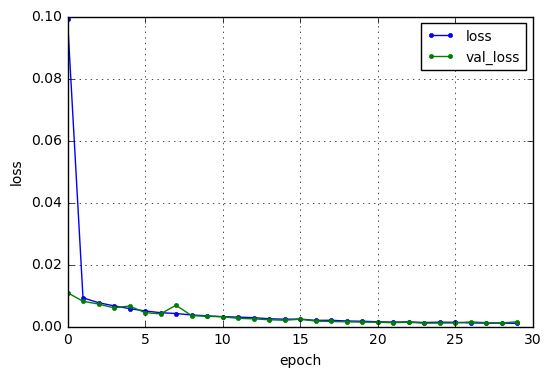

hiden node = 16
_dim=0016_Win=0128_Sld=0032_Adagrad
Train on 8420 samples, validate on 8420 samples
Epoch 1/50
0s - loss: 0.0350 - val_loss: 0.0099
Epoch 2/50
0s - loss: 0.0094 - val_loss: 0.0097
Epoch 3/50
0s - loss: 0.0085 - val_loss: 0.0094
Epoch 4/50
0s - loss: 0.0079 - val_loss: 0.0089
Epoch 5/50
0s - loss: 0.0074 - val_loss: 0.0080
Epoch 6/50
0s - loss: 0.0071 - val_loss: 0.0075
Epoch 7/50
0s - loss: 0.0066 - val_loss: 0.0062
Epoch 8/50
0s - loss: 0.0063 - val_loss: 0.0101
Epoch 9/50
0s - loss: 0.0060 - val_loss: 0.0076
Epoch 10/50
0s - loss: 0.0057 - val_loss: 0.0053
Epoch 11/50
0s - loss: 0.0054 - val_loss: 0.0051
Epoch 12/50
0s - loss: 0.0051 - val_loss: 0.0052
Epoch 13/50
0s - loss: 0.0050 - val_loss: 0.0047
Epoch 14/50
0s - loss: 0.0047 - val_loss: 0.0045
Epoch 15/50
0s - loss: 0.0046 - val_loss: 0.0044
Epoch 16/50
0s - loss: 0.0044 - val_loss: 0.0042
Epoch 17/50
0s - loss: 0.0043 - val_loss: 0.0041
Epoch 18/50
0s - loss: 0.0041 - val_loss: 0.0040
Epoch 19/50
0s - loss: 0.00

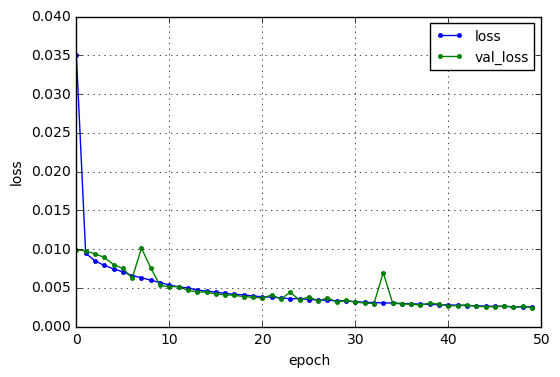

hiden node = 16
_dim=0016_Win=0128_Sld=0032_RMSprop
Train on 8420 samples, validate on 8420 samples
Epoch 1/50
0s - loss: 0.0753 - val_loss: 0.0101
Epoch 2/50
0s - loss: 0.0095 - val_loss: 0.0073
Epoch 3/50
0s - loss: 0.0084 - val_loss: 0.0068
Epoch 4/50
0s - loss: 0.0077 - val_loss: 0.0074
Epoch 5/50
0s - loss: 0.0072 - val_loss: 0.0076
Epoch 6/50
0s - loss: 0.0069 - val_loss: 0.0127
Epoch 7/50
0s - loss: 0.0068 - val_loss: 0.0141
Epoch 8/50
0s - loss: 0.0066 - val_loss: 0.0047
Epoch 9/50
0s - loss: 0.0065 - val_loss: 0.0096
Epoch 10/50
0s - loss: 0.0063 - val_loss: 0.0064
Epoch 11/50
0s - loss: 0.0063 - val_loss: 0.0048
Epoch 12/50
0s - loss: 0.0063 - val_loss: 0.0042
Epoch 13/50
0s - loss: 0.0062 - val_loss: 0.0053
Epoch 14/50
0s - loss: 0.0061 - val_loss: 0.0060
Epoch 15/50
0s - loss: 0.0061 - val_loss: 0.0256
Epoch 16/50
0s - loss: 0.0060 - val_loss: 0.0037
Epoch 17/50
0s - loss: 0.0059 - val_loss: 0.0045
Epoch 18/50
0s - loss: 0.0060 - val_loss: 0.0096
Epoch 19/50
0s - loss: 0.00

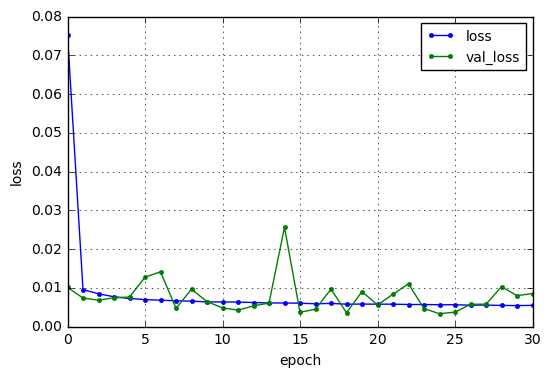

hiden node = 16
_dim=0016_Win=0128_Sld=0032_Nadam
Train on 8420 samples, validate on 8420 samples
Epoch 1/50
0s - loss: 0.0599 - val_loss: 0.0134
Epoch 2/50
0s - loss: 0.0109 - val_loss: 0.0084
Epoch 3/50
0s - loss: 0.0098 - val_loss: 0.0077
Epoch 4/50
0s - loss: 0.0087 - val_loss: 0.0078
Epoch 5/50
0s - loss: 0.0079 - val_loss: 0.0055
Epoch 6/50
0s - loss: 0.0072 - val_loss: 0.0052
Epoch 7/50
0s - loss: 0.0072 - val_loss: 0.0072
Epoch 8/50
0s - loss: 0.0066 - val_loss: 0.0072
Epoch 9/50
0s - loss: 0.0062 - val_loss: 0.0050
Epoch 10/50
0s - loss: 0.0059 - val_loss: 0.0042
Epoch 11/50
0s - loss: 0.0058 - val_loss: 0.0048
Epoch 12/50
0s - loss: 0.0057 - val_loss: 0.0045
Epoch 13/50
0s - loss: 0.0051 - val_loss: 0.0037
Epoch 14/50
0s - loss: 0.0051 - val_loss: 0.0262
Epoch 15/50
0s - loss: 0.0050 - val_loss: 0.0033
Epoch 16/50
0s - loss: 0.0046 - val_loss: 0.0029
Epoch 17/50
0s - loss: 0.0044 - val_loss: 0.0026
Epoch 18/50
0s - loss: 0.0044 - val_loss: 0.0050
Epoch 19/50
0s - loss: 0.0041

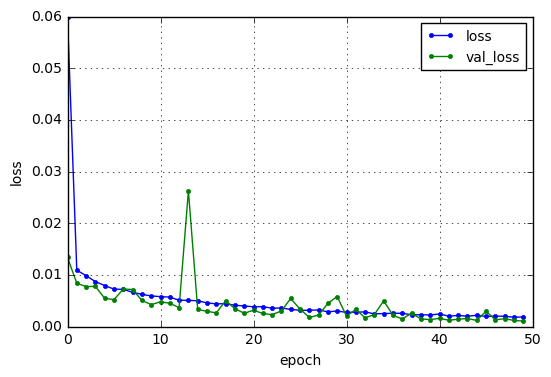

 25%|██▍       | 1044/4209 [00:00<00:00, 10434.26it/s]

AccX is registed now
Build Complete
Source shape is(1077870,)
window frames num =8418
offset=110


100%|██████████| 4209/4209 [00:02<00:00, 1461.38it/s]


hiden node = 16
_dim=0016_Win=0256_Sld=0064_SGD
Train on 4210 samples, validate on 4210 samples
Epoch 1/50
0s - loss: 0.7144 - val_loss: 0.6500
Epoch 2/50
0s - loss: 0.5982 - val_loss: 0.5448
Epoch 3/50
0s - loss: 0.4921 - val_loss: 0.4393
Epoch 4/50
0s - loss: 0.3917 - val_loss: 0.3458
Epoch 5/50
0s - loss: 0.3069 - val_loss: 0.2702
Epoch 6/50
0s - loss: 0.2401 - val_loss: 0.2120
Epoch 7/50
0s - loss: 0.1892 - val_loss: 0.1681
Epoch 8/50
0s - loss: 0.1512 - val_loss: 0.1356
Epoch 9/50
0s - loss: 0.1230 - val_loss: 0.1115
Epoch 10/50
0s - loss: 0.1022 - val_loss: 0.0935
Epoch 11/50
0s - loss: 0.0866 - val_loss: 0.0801
Epoch 12/50
0s - loss: 0.0748 - val_loss: 0.0699
Epoch 13/50
0s - loss: 0.0658 - val_loss: 0.0620
Epoch 14/50
0s - loss: 0.0588 - val_loss: 0.0558
Epoch 15/50
0s - loss: 0.0532 - val_loss: 0.0508
Epoch 16/50
0s - loss: 0.0487 - val_loss: 0.0467
Epoch 17/50
0s - loss: 0.0450 - val_loss: 0.0433
Epoch 18/50
0s - loss: 0.0419 - val_loss: 0.0405
Epoch 19/50
0s - loss: 0.0393 -

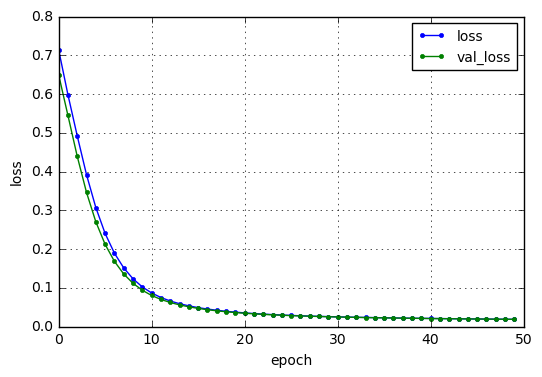

hiden node = 16
_dim=0016_Win=0256_Sld=0064_Adadelta
Train on 4210 samples, validate on 4210 samples
Epoch 1/50
0s - loss: 0.2504 - val_loss: 0.0403
Epoch 2/50
0s - loss: 0.0258 - val_loss: 0.0183
Epoch 3/50
0s - loss: 0.0165 - val_loss: 0.0150
Epoch 4/50
0s - loss: 0.0151 - val_loss: 0.0134
Epoch 5/50
0s - loss: 0.0143 - val_loss: 0.0126
Epoch 6/50
0s - loss: 0.0140 - val_loss: 0.0128
Epoch 7/50
0s - loss: 0.0139 - val_loss: 0.0133
Epoch 8/50
0s - loss: 0.0125 - val_loss: 0.0120
Epoch 9/50
0s - loss: 0.0122 - val_loss: 0.0116
Epoch 10/50
0s - loss: 0.0117 - val_loss: 0.0141
Epoch 11/50
0s - loss: 0.0113 - val_loss: 0.0097
Epoch 12/50
0s - loss: 0.0109 - val_loss: 0.0093
Epoch 13/50
0s - loss: 0.0107 - val_loss: 0.0170
Epoch 14/50
0s - loss: 0.0103 - val_loss: 0.0099
Epoch 15/50
0s - loss: 0.0103 - val_loss: 0.0102
Epoch 16/50
0s - loss: 0.0095 - val_loss: 0.0109
Epoch 17/50
0s - loss: 0.0094 - val_loss: 0.0085
Epoch 18/50
0s - loss: 0.0094 - val_loss: 0.0084
Epoch 19/50
0s - loss: 0.0

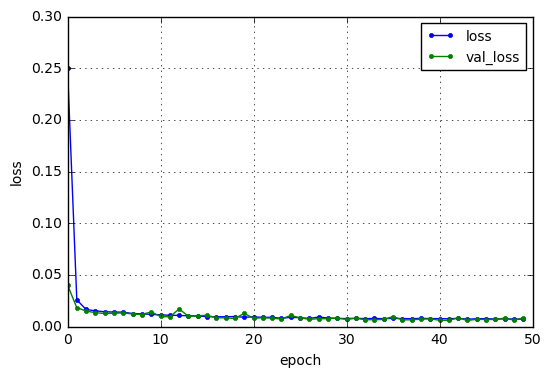

hiden node = 16
_dim=0016_Win=0256_Sld=0064_Adamax
Train on 4210 samples, validate on 4210 samples
Epoch 1/50
0s - loss: 0.1356 - val_loss: 0.0212
Epoch 2/50
0s - loss: 0.0175 - val_loss: 0.0152
Epoch 3/50
0s - loss: 0.0144 - val_loss: 0.0137
Epoch 4/50
0s - loss: 0.0134 - val_loss: 0.0129
Epoch 5/50
0s - loss: 0.0127 - val_loss: 0.0122
Epoch 6/50
0s - loss: 0.0121 - val_loss: 0.0117
Epoch 7/50
0s - loss: 0.0116 - val_loss: 0.0111
Epoch 8/50
0s - loss: 0.0109 - val_loss: 0.0108
Epoch 9/50
0s - loss: 0.0103 - val_loss: 0.0097
Epoch 10/50
0s - loss: 0.0095 - val_loss: 0.0090
Epoch 11/50
0s - loss: 0.0087 - val_loss: 0.0082
Epoch 12/50
0s - loss: 0.0081 - val_loss: 0.0081
Epoch 13/50
0s - loss: 0.0078 - val_loss: 0.0075
Epoch 14/50
0s - loss: 0.0072 - val_loss: 0.0067
Epoch 15/50
0s - loss: 0.0066 - val_loss: 0.0063
Epoch 16/50
0s - loss: 0.0064 - val_loss: 0.0060
Epoch 17/50
0s - loss: 0.0059 - val_loss: 0.0058
Epoch 18/50
0s - loss: 0.0056 - val_loss: 0.0059
Epoch 19/50
0s - loss: 0.005

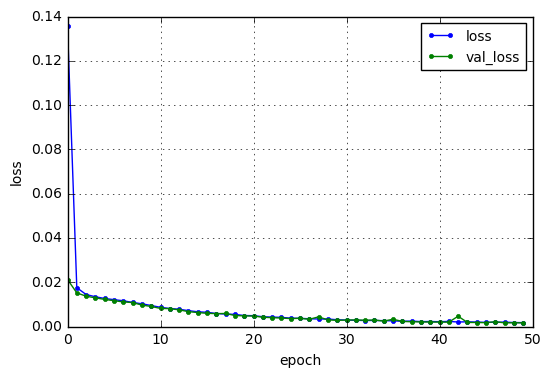

hiden node = 16
_dim=0016_Win=0256_Sld=0064_Adam
Train on 4210 samples, validate on 4210 samples
Epoch 1/50
0s - loss: 0.1677 - val_loss: 0.0226
Epoch 2/50
0s - loss: 0.0170 - val_loss: 0.0143
Epoch 3/50
0s - loss: 0.0137 - val_loss: 0.0139
Epoch 4/50
0s - loss: 0.0128 - val_loss: 0.0122
Epoch 5/50
0s - loss: 0.0120 - val_loss: 0.0111
Epoch 6/50
0s - loss: 0.0109 - val_loss: 0.0104
Epoch 7/50
0s - loss: 0.0101 - val_loss: 0.0095
Epoch 8/50
0s - loss: 0.0093 - val_loss: 0.0087
Epoch 9/50
0s - loss: 0.0085 - val_loss: 0.0097
Epoch 10/50
0s - loss: 0.0079 - val_loss: 0.0072
Epoch 11/50
0s - loss: 0.0073 - val_loss: 0.0066
Epoch 12/50
0s - loss: 0.0067 - val_loss: 0.0067
Epoch 13/50
0s - loss: 0.0063 - val_loss: 0.0062
Epoch 14/50
0s - loss: 0.0061 - val_loss: 0.0059
Epoch 15/50
0s - loss: 0.0059 - val_loss: 0.0059
Epoch 16/50
0s - loss: 0.0056 - val_loss: 0.0085
Epoch 17/50
0s - loss: 0.0056 - val_loss: 0.0050
Epoch 18/50
0s - loss: 0.0050 - val_loss: 0.0059
Epoch 19/50
0s - loss: 0.0050 

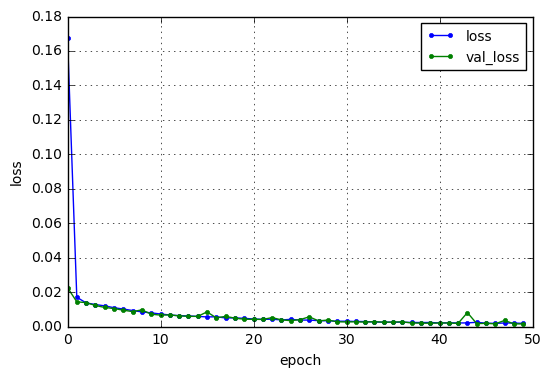

hiden node = 16
_dim=0016_Win=0256_Sld=0064_Adagrad
Train on 4210 samples, validate on 4210 samples
Epoch 1/50
0s - loss: 0.0661 - val_loss: 0.0168
Epoch 2/50
0s - loss: 0.0167 - val_loss: 0.0152
Epoch 3/50
0s - loss: 0.0147 - val_loss: 0.0139
Epoch 4/50
0s - loss: 0.0141 - val_loss: 0.0145
Epoch 5/50
0s - loss: 0.0130 - val_loss: 0.0149
Epoch 6/50
0s - loss: 0.0126 - val_loss: 0.0116
Epoch 7/50
0s - loss: 0.0120 - val_loss: 0.0177
Epoch 8/50
0s - loss: 0.0118 - val_loss: 0.0133
Epoch 9/50
0s - loss: 0.0110 - val_loss: 0.0110
Epoch 10/50
0s - loss: 0.0108 - val_loss: 0.0101
Epoch 11/50
0s - loss: 0.0104 - val_loss: 0.0109
Epoch 12/50
0s - loss: 0.0097 - val_loss: 0.0096
Epoch 13/50
0s - loss: 0.0095 - val_loss: 0.0089
Epoch 14/50
0s - loss: 0.0092 - val_loss: 0.0094
Epoch 15/50
0s - loss: 0.0090 - val_loss: 0.0090
Epoch 16/50
0s - loss: 0.0087 - val_loss: 0.0081
Epoch 17/50
0s - loss: 0.0086 - val_loss: 0.0081
Epoch 18/50
0s - loss: 0.0083 - val_loss: 0.0078
Epoch 19/50
0s - loss: 0.00

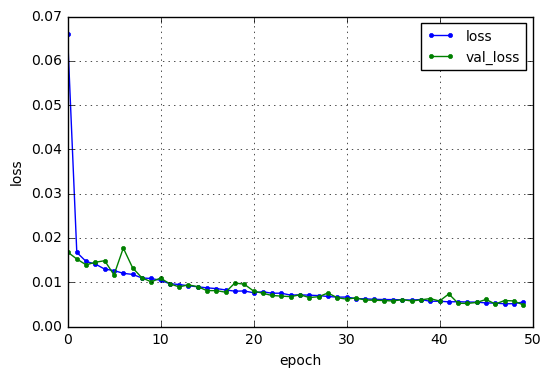

hiden node = 16
_dim=0016_Win=0256_Sld=0064_RMSprop
Train on 4210 samples, validate on 4210 samples
Epoch 1/50
0s - loss: 0.1302 - val_loss: 0.0200
Epoch 2/50
0s - loss: 0.0172 - val_loss: 0.0135
Epoch 3/50
0s - loss: 0.0160 - val_loss: 0.0256
Epoch 4/50
0s - loss: 0.0150 - val_loss: 0.0199
Epoch 5/50
0s - loss: 0.0139 - val_loss: 0.0129
Epoch 6/50
0s - loss: 0.0132 - val_loss: 0.0112
Epoch 7/50
0s - loss: 0.0126 - val_loss: 0.0090
Epoch 8/50
0s - loss: 0.0120 - val_loss: 0.0258
Epoch 9/50
0s - loss: 0.0119 - val_loss: 0.0086
Epoch 10/50
0s - loss: 0.0115 - val_loss: 0.0083
Epoch 11/50
0s - loss: 0.0112 - val_loss: 0.0087
Epoch 12/50
0s - loss: 0.0111 - val_loss: 0.0104
Epoch 13/50
0s - loss: 0.0108 - val_loss: 0.0087
Epoch 14/50
0s - loss: 0.0106 - val_loss: 0.0078
Epoch 15/50
0s - loss: 0.0106 - val_loss: 0.0097
Epoch 16/50
0s - loss: 0.0105 - val_loss: 0.0099
Epoch 17/50
0s - loss: 0.0103 - val_loss: 0.0112
Epoch 18/50
0s - loss: 0.0103 - val_loss: 0.0131
Epoch 19/50
0s - loss: 0.01

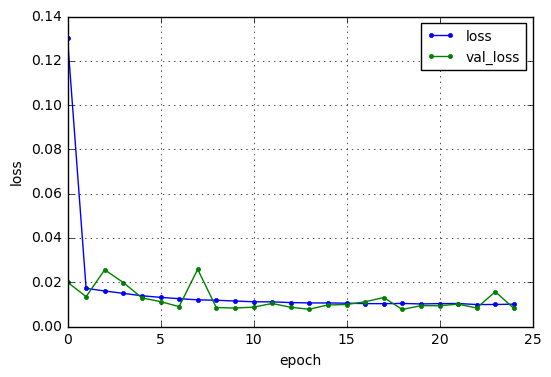

hiden node = 16
_dim=0016_Win=0256_Sld=0064_Nadam
Train on 4210 samples, validate on 4210 samples
Epoch 1/50
0s - loss: 0.1074 - val_loss: 0.0173
Epoch 2/50
0s - loss: 0.0186 - val_loss: 0.0152
Epoch 3/50
0s - loss: 0.0176 - val_loss: 0.0234
Epoch 4/50
0s - loss: 0.0168 - val_loss: 0.0176
Epoch 5/50
0s - loss: 0.0155 - val_loss: 0.0131
Epoch 6/50
0s - loss: 0.0147 - val_loss: 0.0111
Epoch 7/50
0s - loss: 0.0133 - val_loss: 0.0195
Epoch 8/50
0s - loss: 0.0132 - val_loss: 0.0100
Epoch 9/50
0s - loss: 0.0123 - val_loss: 0.0111
Epoch 10/50
0s - loss: 0.0118 - val_loss: 0.0101
Epoch 11/50
0s - loss: 0.0114 - val_loss: 0.0138
Epoch 12/50
0s - loss: 0.0113 - val_loss: 0.0119
Epoch 13/50
0s - loss: 0.0110 - val_loss: 0.0078
Epoch 14/50
0s - loss: 0.0102 - val_loss: 0.0157
Epoch 15/50
0s - loss: 0.0104 - val_loss: 0.0088
Epoch 16/50
0s - loss: 0.0099 - val_loss: 0.0078
Epoch 17/50
0s - loss: 0.0097 - val_loss: 0.0069
Epoch 18/50
0s - loss: 0.0095 - val_loss: 0.0068
Epoch 19/50
0s - loss: 0.0097

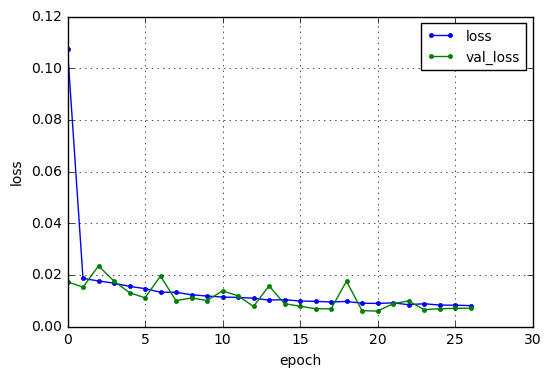

 36%|███▌      | 762/2104 [00:00<00:00, 7605.72it/s]

AccX is registed now
Build Complete
Source shape is(1077870,)
window frames num =4208
offset=110


100%|██████████| 2104/2104 [00:01<00:00, 1434.96it/s]


hiden node = 16
_dim=0016_Win=0512_Sld=0128_SGD
Train on 2105 samples, validate on 2105 samples
Epoch 1/50
0s - loss: 0.7610 - val_loss: 0.7360
Epoch 2/50
0s - loss: 0.7172 - val_loss: 0.6983
Epoch 3/50
0s - loss: 0.6800 - val_loss: 0.6608
Epoch 4/50
0s - loss: 0.6420 - val_loss: 0.6223
Epoch 5/50
0s - loss: 0.6034 - val_loss: 0.5838
Epoch 6/50
0s - loss: 0.5653 - val_loss: 0.5463
Epoch 7/50
0s - loss: 0.5286 - val_loss: 0.5105
Epoch 8/50
0s - loss: 0.4936 - val_loss: 0.4765
Epoch 9/50
0s - loss: 0.4608 - val_loss: 0.4448
Epoch 10/50
0s - loss: 0.4301 - val_loss: 0.4152
Epoch 11/50
0s - loss: 0.4015 - val_loss: 0.3877
Epoch 12/50
0s - loss: 0.3751 - val_loss: 0.3623
Epoch 13/50
0s - loss: 0.3506 - val_loss: 0.3388
Epoch 14/50
0s - loss: 0.3280 - val_loss: 0.3170
Epoch 15/50
0s - loss: 0.3071 - val_loss: 0.2970
Epoch 16/50
0s - loss: 0.2877 - val_loss: 0.2784
Epoch 17/50
0s - loss: 0.2699 - val_loss: 0.2613
Epoch 18/50
0s - loss: 0.2534 - val_loss: 0.2455
Epoch 19/50
0s - loss: 0.2382 -

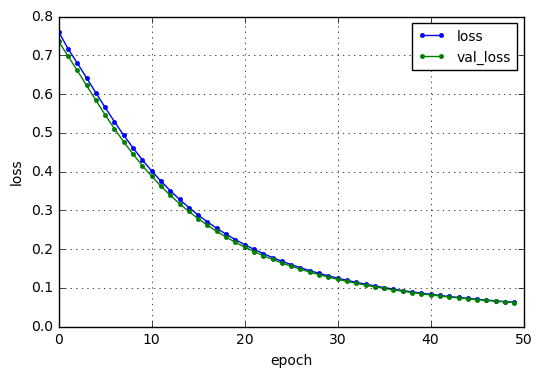

hiden node = 16
_dim=0016_Win=0512_Sld=0128_Adadelta
Train on 2105 samples, validate on 2105 samples
Epoch 1/50
0s - loss: 0.4021 - val_loss: 0.1552
Epoch 2/50
0s - loss: 0.0897 - val_loss: 0.0526
Epoch 3/50
0s - loss: 0.0394 - val_loss: 0.0305
Epoch 4/50
0s - loss: 0.0270 - val_loss: 0.0235
Epoch 5/50
0s - loss: 0.0235 - val_loss: 0.0233
Epoch 6/50
0s - loss: 0.0226 - val_loss: 0.0204
Epoch 7/50
0s - loss: 0.0212 - val_loss: 0.0196
Epoch 8/50
0s - loss: 0.0207 - val_loss: 0.0230
Epoch 9/50
0s - loss: 0.0206 - val_loss: 0.0200
Epoch 10/50
0s - loss: 0.0202 - val_loss: 0.0193
Epoch 11/50
0s - loss: 0.0206 - val_loss: 0.0203
Epoch 12/50
0s - loss: 0.0193 - val_loss: 0.0223
Epoch 13/50
0s - loss: 0.0199 - val_loss: 0.0190
Epoch 14/50
0s - loss: 0.0202 - val_loss: 0.0177
Epoch 15/50
0s - loss: 0.0193 - val_loss: 0.0180
Epoch 16/50
0s - loss: 0.0192 - val_loss: 0.0173
Epoch 17/50
0s - loss: 0.0191 - val_loss: 0.0191
Epoch 18/50
0s - loss: 0.0193 - val_loss: 0.0170
Epoch 19/50
0s - loss: 0.0

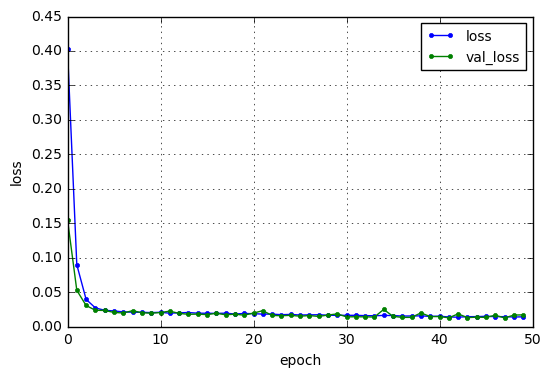

hiden node = 16
_dim=0016_Win=0512_Sld=0128_Adamax
Train on 2105 samples, validate on 2105 samples
Epoch 1/50
0s - loss: 0.2279 - val_loss: 0.0364
Epoch 2/50
0s - loss: 0.0281 - val_loss: 0.0239
Epoch 3/50
0s - loss: 0.0225 - val_loss: 0.0217
Epoch 4/50
0s - loss: 0.0201 - val_loss: 0.0193
Epoch 5/50
0s - loss: 0.0193 - val_loss: 0.0188
Epoch 6/50
0s - loss: 0.0185 - val_loss: 0.0181
Epoch 7/50
0s - loss: 0.0182 - val_loss: 0.0178
Epoch 8/50
0s - loss: 0.0179 - val_loss: 0.0176
Epoch 9/50
0s - loss: 0.0176 - val_loss: 0.0183
Epoch 10/50
0s - loss: 0.0173 - val_loss: 0.0169
Epoch 11/50
0s - loss: 0.0169 - val_loss: 0.0167
Epoch 12/50
0s - loss: 0.0167 - val_loss: 0.0162
Epoch 13/50
0s - loss: 0.0164 - val_loss: 0.0160
Epoch 14/50
0s - loss: 0.0162 - val_loss: 0.0153
Epoch 15/50
0s - loss: 0.0152 - val_loss: 0.0149
Epoch 16/50
0s - loss: 0.0149 - val_loss: 0.0151
Epoch 17/50
0s - loss: 0.0144 - val_loss: 0.0139
Epoch 18/50
0s - loss: 0.0137 - val_loss: 0.0142
Epoch 19/50
0s - loss: 0.013

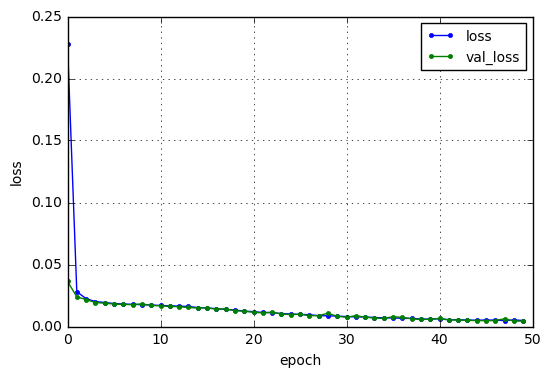

hiden node = 16
_dim=0016_Win=0512_Sld=0128_Adam
Train on 2105 samples, validate on 2105 samples
Epoch 1/50
0s - loss: 0.2992 - val_loss: 0.0604
Epoch 2/50
0s - loss: 0.0356 - val_loss: 0.0257
Epoch 3/50
0s - loss: 0.0222 - val_loss: 0.0201
Epoch 4/50
0s - loss: 0.0196 - val_loss: 0.0187
Epoch 5/50
0s - loss: 0.0186 - val_loss: 0.0177
Epoch 6/50
0s - loss: 0.0180 - val_loss: 0.0170
Epoch 7/50
0s - loss: 0.0173 - val_loss: 0.0165
Epoch 8/50
0s - loss: 0.0164 - val_loss: 0.0159
Epoch 9/50
0s - loss: 0.0157 - val_loss: 0.0152
Epoch 10/50
0s - loss: 0.0146 - val_loss: 0.0143
Epoch 11/50
0s - loss: 0.0139 - val_loss: 0.0134
Epoch 12/50
0s - loss: 0.0136 - val_loss: 0.0134
Epoch 13/50
0s - loss: 0.0131 - val_loss: 0.0124
Epoch 14/50
0s - loss: 0.0126 - val_loss: 0.0124
Epoch 15/50
0s - loss: 0.0121 - val_loss: 0.0115
Epoch 16/50
0s - loss: 0.0119 - val_loss: 0.0111
Epoch 17/50
0s - loss: 0.0111 - val_loss: 0.0105
Epoch 18/50
0s - loss: 0.0108 - val_loss: 0.0101
Epoch 19/50
0s - loss: 0.0103 

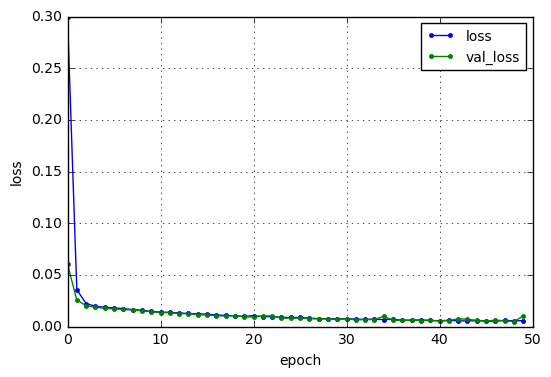

hiden node = 16
_dim=0016_Win=0512_Sld=0128_Adagrad
Train on 2105 samples, validate on 2105 samples
Epoch 1/50
0s - loss: 0.1335 - val_loss: 0.0465
Epoch 2/50
0s - loss: 0.0301 - val_loss: 0.0237
Epoch 3/50
0s - loss: 0.0245 - val_loss: 0.0227
Epoch 4/50
0s - loss: 0.0226 - val_loss: 0.0201
Epoch 5/50
0s - loss: 0.0212 - val_loss: 0.0192
Epoch 6/50
0s - loss: 0.0215 - val_loss: 0.0228
Epoch 7/50
0s - loss: 0.0213 - val_loss: 0.0191
Epoch 8/50
0s - loss: 0.0203 - val_loss: 0.0183
Epoch 9/50
0s - loss: 0.0200 - val_loss: 0.0201
Epoch 10/50
0s - loss: 0.0192 - val_loss: 0.0192
Epoch 11/50
0s - loss: 0.0190 - val_loss: 0.0174
Epoch 12/50
0s - loss: 0.0184 - val_loss: 0.0170
Epoch 13/50
0s - loss: 0.0183 - val_loss: 0.0169
Epoch 14/50
0s - loss: 0.0178 - val_loss: 0.0167
Epoch 15/50
0s - loss: 0.0173 - val_loss: 0.0171
Epoch 16/50
0s - loss: 0.0181 - val_loss: 0.0170
Epoch 17/50
0s - loss: 0.0167 - val_loss: 0.0156
Epoch 18/50
0s - loss: 0.0164 - val_loss: 0.0181
Epoch 19/50
0s - loss: 0.01

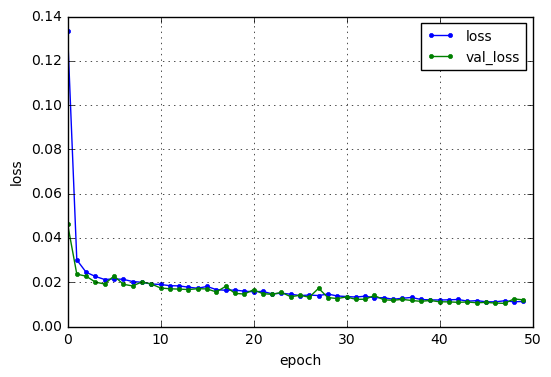

hiden node = 16
_dim=0016_Win=0512_Sld=0128_RMSprop
Train on 2105 samples, validate on 2105 samples
Epoch 1/50
0s - loss: 0.2331 - val_loss: 0.0459
Epoch 2/50
0s - loss: 0.0321 - val_loss: 0.0228
Epoch 3/50
0s - loss: 0.0264 - val_loss: 0.0430
Epoch 4/50
0s - loss: 0.0258 - val_loss: 0.0204
Epoch 5/50
0s - loss: 0.0244 - val_loss: 0.0194
Epoch 6/50
0s - loss: 0.0232 - val_loss: 0.0221
Epoch 7/50
0s - loss: 0.0231 - val_loss: 0.0175
Epoch 8/50
0s - loss: 0.0223 - val_loss: 0.0260
Epoch 9/50
0s - loss: 0.0210 - val_loss: 0.0225
Epoch 10/50
0s - loss: 0.0204 - val_loss: 0.0180
Epoch 11/50
0s - loss: 0.0204 - val_loss: 0.0164
Epoch 12/50
0s - loss: 0.0199 - val_loss: 0.0230
Epoch 13/50
0s - loss: 0.0193 - val_loss: 0.0144
Epoch 14/50
0s - loss: 0.0197 - val_loss: 0.0164
Epoch 15/50
0s - loss: 0.0184 - val_loss: 0.0137
Epoch 16/50
0s - loss: 0.0186 - val_loss: 0.0154
Epoch 17/50
0s - loss: 0.0180 - val_loss: 0.0186
Epoch 18/50
0s - loss: 0.0183 - val_loss: 0.0130
Epoch 19/50
0s - loss: 0.01

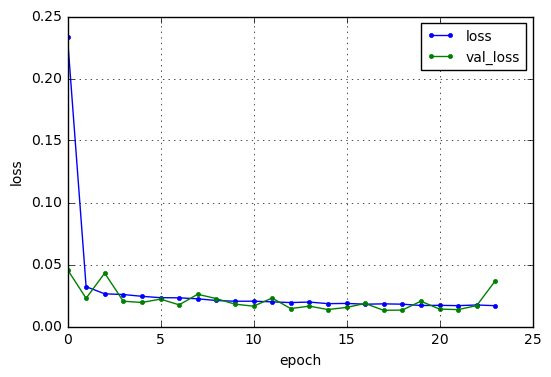

hiden node = 16
_dim=0016_Win=0512_Sld=0128_Nadam
Train on 2105 samples, validate on 2105 samples
Epoch 1/50
0s - loss: 0.1907 - val_loss: 0.0321
Epoch 2/50
0s - loss: 0.0368 - val_loss: 0.0312
Epoch 3/50
0s - loss: 0.0290 - val_loss: 0.0827
Epoch 4/50
0s - loss: 0.0350 - val_loss: 0.0225
Epoch 5/50
0s - loss: 0.0230 - val_loss: 0.0483
Epoch 6/50
0s - loss: 0.0264 - val_loss: 0.0262
Epoch 7/50
0s - loss: 0.0220 - val_loss: 0.0309
Epoch 8/50
0s - loss: 0.0247 - val_loss: 0.0320
Epoch 9/50
0s - loss: 0.0228 - val_loss: 0.0216
Epoch 10/50
0s - loss: 0.0203 - val_loss: 0.0460
Epoch 11/50
0s - loss: 0.0207 - val_loss: 0.0156
Epoch 12/50
0s - loss: 0.0194 - val_loss: 0.0278
Epoch 13/50
0s - loss: 0.0234 - val_loss: 0.0245
Epoch 14/50
0s - loss: 0.0232 - val_loss: 0.0371
Epoch 15/50
0s - loss: 0.0246 - val_loss: 0.0265
Epoch 16/50
0s - loss: 0.0209 - val_loss: 0.0236
Epoch 17/50
0s - loss: 0.0179 - val_loss: 0.0181
2105/2105 [==============================] - 0s     


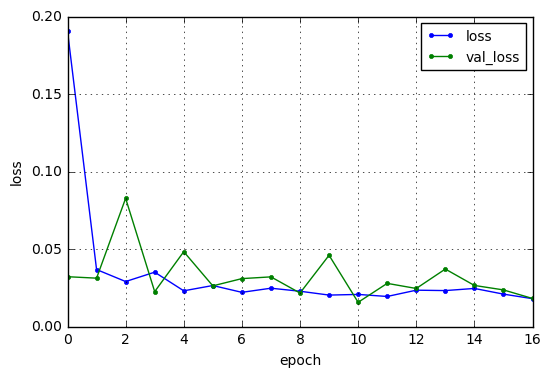

 45%|████▌     | 474/1051 [00:00<00:00, 4730.87it/s]

AccX is registed now
Build Complete
Source shape is(1077870,)
window frames num =2103
offset=110


100%|██████████| 1051/1051 [00:00<00:00, 1374.92it/s]


hiden node = 16
_dim=0016_Win=1024_Sld=0256_SGD
Train on 1052 samples, validate on 1052 samples
Epoch 1/50
0s - loss: 0.7600 - val_loss: 0.7505
Epoch 2/50
0s - loss: 0.7440 - val_loss: 0.7382
Epoch 3/50
0s - loss: 0.7343 - val_loss: 0.7303
Epoch 4/50
0s - loss: 0.7267 - val_loss: 0.7228
Epoch 5/50
0s - loss: 0.7192 - val_loss: 0.7152
Epoch 6/50
0s - loss: 0.7114 - val_loss: 0.7073
Epoch 7/50
0s - loss: 0.7033 - val_loss: 0.6990
Epoch 8/50
0s - loss: 0.6948 - val_loss: 0.6903
Epoch 9/50
0s - loss: 0.6860 - val_loss: 0.6813
Epoch 10/50
0s - loss: 0.6768 - val_loss: 0.6719
Epoch 11/50
0s - loss: 0.6672 - val_loss: 0.6622
Epoch 12/50
0s - loss: 0.6575 - val_loss: 0.6524
Epoch 13/50
0s - loss: 0.6476 - val_loss: 0.6424
Epoch 14/50
0s - loss: 0.6375 - val_loss: 0.6323
Epoch 15/50
0s - loss: 0.6274 - val_loss: 0.6222
Epoch 16/50
0s - loss: 0.6173 - val_loss: 0.6121
Epoch 17/50
0s - loss: 0.6072 - val_loss: 0.6020
Epoch 18/50
0s - loss: 0.5972 - val_loss: 0.5921
Epoch 19/50
0s - loss: 0.5873 -

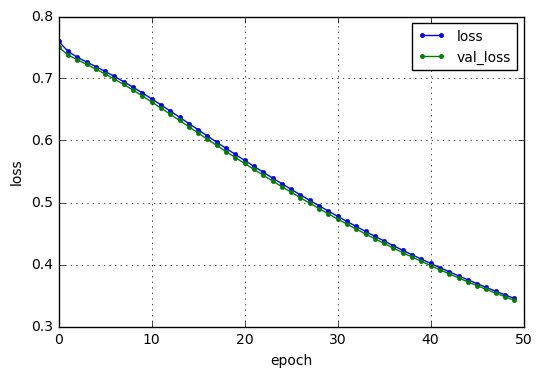

hiden node = 16
_dim=0016_Win=1024_Sld=0256_Adadelta
Train on 1052 samples, validate on 1052 samples
Epoch 1/50
0s - loss: 0.5837 - val_loss: 0.4094
Epoch 2/50
0s - loss: 0.3051 - val_loss: 0.2182
Epoch 3/50
0s - loss: 0.1683 - val_loss: 0.1263
Epoch 4/50
0s - loss: 0.1014 - val_loss: 0.0801
Epoch 5/50
0s - loss: 0.0676 - val_loss: 0.0560
Epoch 6/50
0s - loss: 0.0497 - val_loss: 0.0429
Epoch 7/50
0s - loss: 0.0403 - val_loss: 0.0358
Epoch 8/50
0s - loss: 0.0352 - val_loss: 0.0366
Epoch 9/50
0s - loss: 0.0318 - val_loss: 0.0294
Epoch 10/50
0s - loss: 0.0304 - val_loss: 0.0296
Epoch 11/50
0s - loss: 0.0292 - val_loss: 0.0262
Epoch 12/50
0s - loss: 0.0286 - val_loss: 0.0256
Epoch 13/50
0s - loss: 0.0298 - val_loss: 0.0319
Epoch 14/50
0s - loss: 0.0280 - val_loss: 0.0249
Epoch 15/50
0s - loss: 0.0274 - val_loss: 0.0247
Epoch 16/50
0s - loss: 0.0252 - val_loss: 0.0258
Epoch 17/50
0s - loss: 0.0265 - val_loss: 0.0238
Epoch 18/50
0s - loss: 0.0256 - val_loss: 0.0235
Epoch 19/50
0s - loss: 0.0

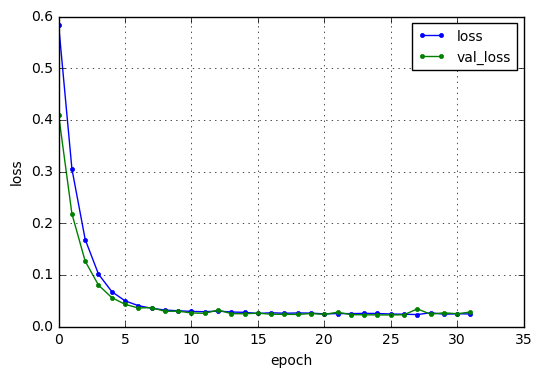

hiden node = 16
_dim=0016_Win=1024_Sld=0256_Adamax
Train on 1052 samples, validate on 1052 samples
Epoch 1/50
0s - loss: 0.3717 - val_loss: 0.1112
Epoch 2/50
0s - loss: 0.0645 - val_loss: 0.0408
Epoch 3/50
0s - loss: 0.0346 - val_loss: 0.0312
Epoch 4/50
0s - loss: 0.0296 - val_loss: 0.0277
Epoch 5/50
0s - loss: 0.0278 - val_loss: 0.0259
Epoch 6/50
0s - loss: 0.0258 - val_loss: 0.0260
Epoch 7/50
0s - loss: 0.0255 - val_loss: 0.0272
Epoch 8/50
0s - loss: 0.0246 - val_loss: 0.0244
Epoch 9/50
0s - loss: 0.0239 - val_loss: 0.0230
Epoch 10/50
0s - loss: 0.0230 - val_loss: 0.0226
Epoch 11/50
0s - loss: 0.0228 - val_loss: 0.0221
Epoch 12/50
0s - loss: 0.0224 - val_loss: 0.0229
Epoch 13/50
0s - loss: 0.0220 - val_loss: 0.0217
Epoch 14/50
0s - loss: 0.0215 - val_loss: 0.0220
Epoch 15/50
0s - loss: 0.0214 - val_loss: 0.0223
Epoch 16/50
0s - loss: 0.0215 - val_loss: 0.0206
Epoch 17/50
0s - loss: 0.0208 - val_loss: 0.0207
Epoch 18/50
0s - loss: 0.0209 - val_loss: 0.0201
Epoch 19/50
0s - loss: 0.020

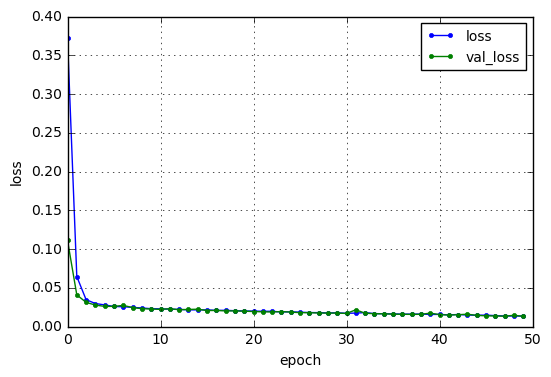

hiden node = 16
_dim=0016_Win=1024_Sld=0256_Adam
Train on 1052 samples, validate on 1052 samples
Epoch 1/50
0s - loss: 0.4783 - val_loss: 0.2158
Epoch 2/50
0s - loss: 0.1209 - val_loss: 0.0628
Epoch 3/50
0s - loss: 0.0457 - val_loss: 0.0346
Epoch 4/50
0s - loss: 0.0336 - val_loss: 0.0357
Epoch 5/50
0s - loss: 0.0327 - val_loss: 0.0282
Epoch 6/50
0s - loss: 0.0278 - val_loss: 0.0262
Epoch 7/50
0s - loss: 0.0268 - val_loss: 0.0249
Epoch 8/50
0s - loss: 0.0249 - val_loss: 0.0287
Epoch 9/50
0s - loss: 0.0264 - val_loss: 0.0240
Epoch 10/50
0s - loss: 0.0233 - val_loss: 0.0223
Epoch 11/50
0s - loss: 0.0223 - val_loss: 0.0217
Epoch 12/50
0s - loss: 0.0218 - val_loss: 0.0211
Epoch 13/50
0s - loss: 0.0222 - val_loss: 0.0230
Epoch 14/50
0s - loss: 0.0213 - val_loss: 0.0205
Epoch 15/50
0s - loss: 0.0204 - val_loss: 0.0204
Epoch 16/50
0s - loss: 0.0199 - val_loss: 0.0200
Epoch 17/50
0s - loss: 0.0218 - val_loss: 0.0200
Epoch 18/50
0s - loss: 0.0201 - val_loss: 0.0191
Epoch 19/50
0s - loss: 0.0189 

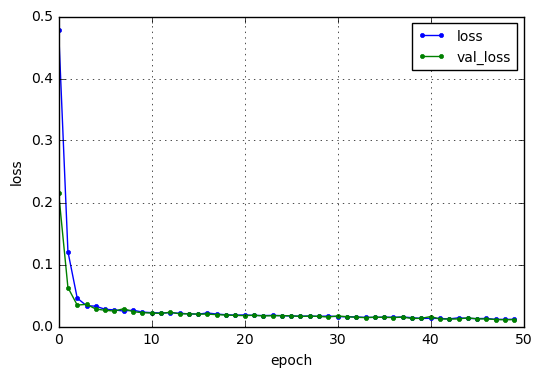

hiden node = 16
_dim=0016_Win=1024_Sld=0256_Adagrad
Train on 1052 samples, validate on 1052 samples
Epoch 1/50
0s - loss: 0.2160 - val_loss: 0.0901
Epoch 2/50
0s - loss: 0.0755 - val_loss: 0.0641
Epoch 3/50
0s - loss: 0.0502 - val_loss: 0.0383
Epoch 4/50
0s - loss: 0.0346 - val_loss: 0.0486
Epoch 5/50
0s - loss: 0.0352 - val_loss: 0.0386
Epoch 6/50
0s - loss: 0.0335 - val_loss: 0.0281
Epoch 7/50
0s - loss: 0.0308 - val_loss: 0.0321
Epoch 8/50
0s - loss: 0.0285 - val_loss: 0.0321
Epoch 9/50
0s - loss: 0.0309 - val_loss: 0.0244
Epoch 10/50
0s - loss: 0.0302 - val_loss: 0.0242
Epoch 11/50
0s - loss: 0.0258 - val_loss: 0.0234
Epoch 12/50
0s - loss: 0.0286 - val_loss: 0.0252
Epoch 13/50
0s - loss: 0.0264 - val_loss: 0.0229
Epoch 14/50
0s - loss: 0.0240 - val_loss: 0.0271
Epoch 15/50
0s - loss: 0.0252 - val_loss: 0.0225
Epoch 16/50
0s - loss: 0.0245 - val_loss: 0.0218
Epoch 17/50
0s - loss: 0.0239 - val_loss: 0.0236
Epoch 18/50
0s - loss: 0.0243 - val_loss: 0.0210
Epoch 19/50
0s - loss: 0.02

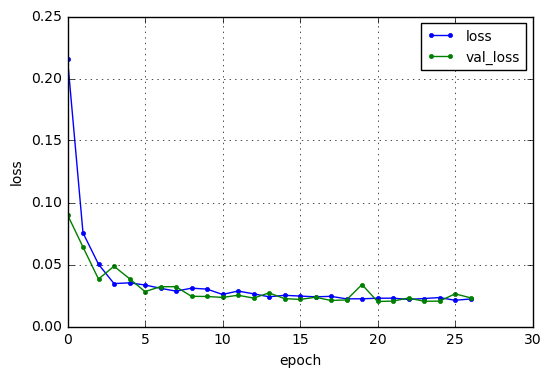

hiden node = 16
_dim=0016_Win=1024_Sld=0256_RMSprop
Train on 1052 samples, validate on 1052 samples
Epoch 1/50
0s - loss: 0.4171 - val_loss: 0.1743
Epoch 2/50
0s - loss: 0.0983 - val_loss: 0.0484
Epoch 3/50
0s - loss: 0.0450 - val_loss: 0.0349
Epoch 4/50
0s - loss: 0.0390 - val_loss: 0.0293
Epoch 5/50
0s - loss: 0.0372 - val_loss: 0.0297
Epoch 6/50
0s - loss: 0.0367 - val_loss: 0.0502
Epoch 7/50
0s - loss: 0.0362 - val_loss: 0.0425
Epoch 8/50
0s - loss: 0.0339 - val_loss: 0.0281
Epoch 9/50
0s - loss: 0.0338 - val_loss: 0.0276
Epoch 10/50
0s - loss: 0.0321 - val_loss: 0.0580
Epoch 11/50
0s - loss: 0.0326 - val_loss: 0.0231
Epoch 12/50
0s - loss: 0.0324 - val_loss: 0.0285
Epoch 13/50
0s - loss: 0.0331 - val_loss: 0.0231
Epoch 14/50
0s - loss: 0.0295 - val_loss: 0.0283
Epoch 15/50
0s - loss: 0.0320 - val_loss: 0.0285
Epoch 16/50
0s - loss: 0.0329 - val_loss: 0.0483
Epoch 17/50
0s - loss: 0.0312 - val_loss: 0.0234
Epoch 18/50
0s - loss: 0.0293 - val_loss: 0.0265
Epoch 19/50
0s - loss: 0.03

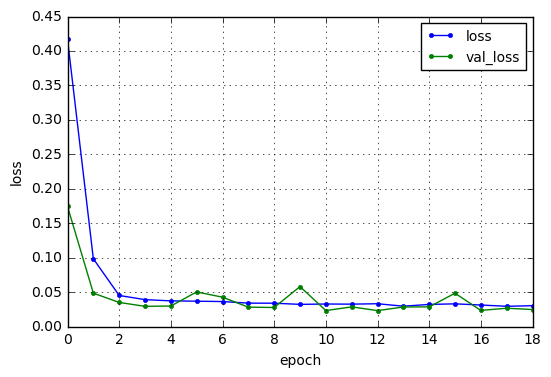

hiden node = 16
_dim=0016_Win=1024_Sld=0256_Nadam
Train on 1052 samples, validate on 1052 samples
Epoch 1/50
0s - loss: 0.3572 - val_loss: 0.0853
Epoch 2/50
0s - loss: 0.0843 - val_loss: 0.0808
Epoch 3/50
0s - loss: 0.0757 - val_loss: 0.0661
Epoch 4/50
0s - loss: 0.0595 - val_loss: 0.0957
Epoch 5/50
0s - loss: 0.0718 - val_loss: 0.0573
Epoch 6/50
0s - loss: 0.0589 - val_loss: 0.0564
Epoch 7/50
0s - loss: 0.0575 - val_loss: 0.0440
Epoch 8/50
0s - loss: 0.0470 - val_loss: 0.0651
Epoch 9/50
0s - loss: 0.0521 - val_loss: 0.0468
Epoch 10/50
0s - loss: 0.0426 - val_loss: 0.0342
Epoch 11/50
0s - loss: 0.0456 - val_loss: 0.0337
Epoch 12/50
0s - loss: 0.0516 - val_loss: 0.0552
Epoch 13/50
0s - loss: 0.0403 - val_loss: 0.0344
Epoch 14/50
0s - loss: 0.0596 - val_loss: 0.0635
Epoch 15/50
0s - loss: 0.0525 - val_loss: 0.0517
Epoch 16/50
0s - loss: 0.0434 - val_loss: 0.0351
Epoch 17/50
0s - loss: 0.0422 - val_loss: 0.0399
  32/1052 [..............................] - ETA: 0s

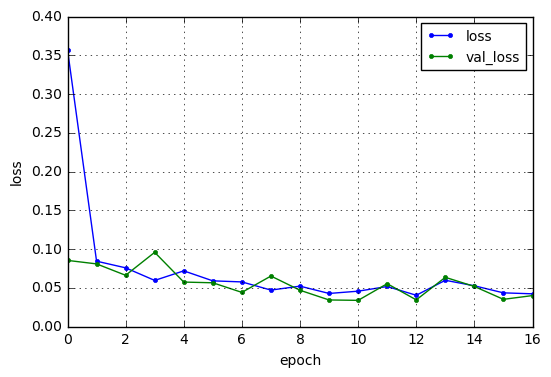

 56%|█████▌    | 295/525 [00:00<00:00, 2930.43it/s]

AccX is registed now
Build Complete
Source shape is(1077870,)
window frames num =1050
offset=622


100%|██████████| 525/525 [00:00<00:00, 1311.15it/s]


hiden node = 16
_dim=0016_Win=2048_Sld=0512_SGD
Train on 526 samples, validate on 526 samples
Epoch 1/50
0s - loss: 0.7508 - val_loss: 0.7489
Epoch 2/50
0s - loss: 0.7475 - val_loss: 0.7459
Epoch 3/50
0s - loss: 0.7447 - val_loss: 0.7432
Epoch 4/50
0s - loss: 0.7419 - val_loss: 0.7405
Epoch 5/50
0s - loss: 0.7393 - val_loss: 0.7378
Epoch 6/50
0s - loss: 0.7366 - val_loss: 0.7352
Epoch 7/50
0s - loss: 0.7339 - val_loss: 0.7323
Epoch 8/50
0s - loss: 0.7310 - val_loss: 0.7294
Epoch 9/50
0s - loss: 0.7282 - val_loss: 0.7267
Epoch 10/50
0s - loss: 0.7255 - val_loss: 0.7241
Epoch 11/50
0s - loss: 0.7230 - val_loss: 0.7216
Epoch 12/50
0s - loss: 0.7204 - val_loss: 0.7191
Epoch 13/50
0s - loss: 0.7179 - val_loss: 0.7165
Epoch 14/50
0s - loss: 0.7153 - val_loss: 0.7139
Epoch 15/50
0s - loss: 0.7127 - val_loss: 0.7112
Epoch 16/50
0s - loss: 0.7100 - val_loss: 0.7085
Epoch 17/50
0s - loss: 0.7073 - val_loss: 0.7057
Epoch 18/50
0s - loss: 0.7045 - val_loss: 0.7030
Epoch 19/50
0s - loss: 0.7017 - v

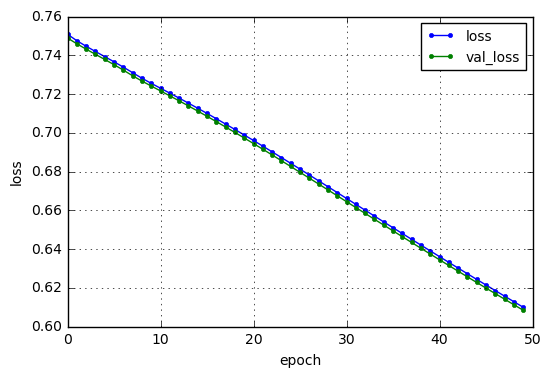

hiden node = 16
_dim=0016_Win=2048_Sld=0512_Adadelta
Train on 526 samples, validate on 526 samples
Epoch 1/50
0s - loss: 0.6892 - val_loss: 0.5954
Epoch 2/50
0s - loss: 0.5226 - val_loss: 0.4441
Epoch 3/50
0s - loss: 0.3911 - val_loss: 0.3339
Epoch 4/50
0s - loss: 0.2961 - val_loss: 0.2555
Epoch 5/50
0s - loss: 0.2281 - val_loss: 0.1986
Epoch 6/50
0s - loss: 0.1786 - val_loss: 0.1567
Epoch 7/50
0s - loss: 0.1420 - val_loss: 0.1263
Epoch 8/50
0s - loss: 0.1157 - val_loss: 0.1037
Epoch 9/50
0s - loss: 0.0960 - val_loss: 0.0919
Epoch 10/50
0s - loss: 0.0824 - val_loss: 0.0746
Epoch 11/50
0s - loss: 0.0703 - val_loss: 0.0667
Epoch 12/50
0s - loss: 0.0621 - val_loss: 0.0597
Epoch 13/50
0s - loss: 0.0558 - val_loss: 0.0681
Epoch 14/50
0s - loss: 0.0536 - val_loss: 0.0486
Epoch 15/50
0s - loss: 0.0471 - val_loss: 0.0455
Epoch 16/50
0s - loss: 0.0448 - val_loss: 0.0439
Epoch 17/50
0s - loss: 0.0435 - val_loss: 0.0421
Epoch 18/50
0s - loss: 0.0405 - val_loss: 0.0409
Epoch 19/50
0s - loss: 0.039

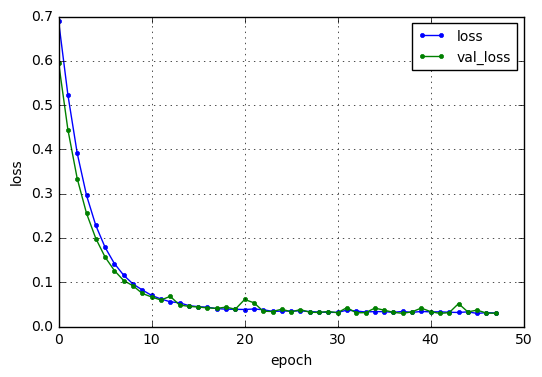

hiden node = 16
_dim=0016_Win=2048_Sld=0512_Adamax
Train on 526 samples, validate on 526 samples
Epoch 1/50
0s - loss: 0.5795 - val_loss: 0.3253
Epoch 2/50
0s - loss: 0.2086 - val_loss: 0.1167
Epoch 3/50
0s - loss: 0.0889 - val_loss: 0.0670
Epoch 4/50
0s - loss: 0.0589 - val_loss: 0.0514
Epoch 5/50
0s - loss: 0.0481 - val_loss: 0.0449
Epoch 6/50
0s - loss: 0.0424 - val_loss: 0.0437
Epoch 7/50
0s - loss: 0.0392 - val_loss: 0.0380
Epoch 8/50
0s - loss: 0.0368 - val_loss: 0.0363
Epoch 9/50
0s - loss: 0.0352 - val_loss: 0.0336
Epoch 10/50
0s - loss: 0.0329 - val_loss: 0.0318
Epoch 11/50
0s - loss: 0.0318 - val_loss: 0.0316
Epoch 12/50
0s - loss: 0.0311 - val_loss: 0.0305
Epoch 13/50
0s - loss: 0.0307 - val_loss: 0.0310
Epoch 14/50
0s - loss: 0.0302 - val_loss: 0.0308
Epoch 15/50
0s - loss: 0.0293 - val_loss: 0.0288
Epoch 16/50
0s - loss: 0.0295 - val_loss: 0.0291
Epoch 17/50
0s - loss: 0.0284 - val_loss: 0.0278
Epoch 18/50
0s - loss: 0.0281 - val_loss: 0.0272
Epoch 19/50
0s - loss: 0.0272 

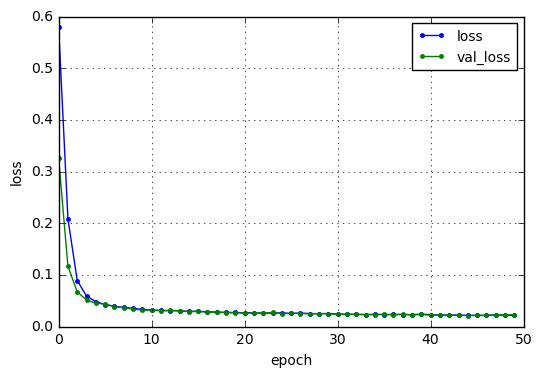

hiden node = 16
_dim=0016_Win=2048_Sld=0512_Adam
Train on 526 samples, validate on 526 samples
Epoch 1/50
0s - loss: 0.6249 - val_loss: 0.4434
Epoch 2/50
0s - loss: 0.3239 - val_loss: 0.2097
Epoch 3/50
0s - loss: 0.1576 - val_loss: 0.1117
Epoch 4/50
0s - loss: 0.0909 - val_loss: 0.0751
Epoch 5/50
0s - loss: 0.0651 - val_loss: 0.0568
Epoch 6/50
0s - loss: 0.0566 - val_loss: 0.0551
Epoch 7/50
0s - loss: 0.0494 - val_loss: 0.0443
Epoch 8/50
0s - loss: 0.0438 - val_loss: 0.0419
Epoch 9/50
0s - loss: 0.0395 - val_loss: 0.0393
Epoch 10/50
0s - loss: 0.0376 - val_loss: 0.0353
Epoch 11/50
0s - loss: 0.0355 - val_loss: 0.0343
Epoch 12/50
0s - loss: 0.0348 - val_loss: 0.0344
Epoch 13/50
0s - loss: 0.0395 - val_loss: 0.0363
Epoch 14/50
0s - loss: 0.0361 - val_loss: 0.0328
Epoch 15/50
0s - loss: 0.0317 - val_loss: 0.0307
Epoch 16/50
0s - loss: 0.0301 - val_loss: 0.0292
Epoch 17/50
0s - loss: 0.0282 - val_loss: 0.0273
Epoch 18/50
0s - loss: 0.0279 - val_loss: 0.0315
Epoch 19/50
0s - loss: 0.0334 - 

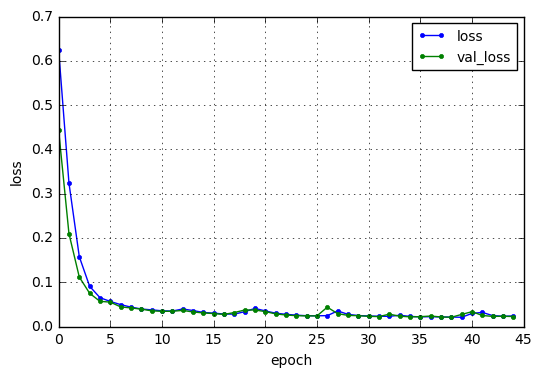

hiden node = 16
_dim=0016_Win=2048_Sld=0512_Adagrad
Train on 526 samples, validate on 526 samples
Epoch 1/50
0s - loss: 0.3692 - val_loss: 0.1503
Epoch 2/50
0s - loss: 0.2272 - val_loss: 0.1471
Epoch 3/50
0s - loss: 0.1372 - val_loss: 0.1250
Epoch 4/50
0s - loss: 0.1103 - val_loss: 0.1459
Epoch 5/50
0s - loss: 0.0988 - val_loss: 0.0948
Epoch 6/50
0s - loss: 0.0936 - val_loss: 0.0874
Epoch 7/50
0s - loss: 0.0923 - val_loss: 0.0854
Epoch 8/50
0s - loss: 0.0838 - val_loss: 0.0838
Epoch 9/50
0s - loss: 0.0805 - val_loss: 0.0793
Epoch 10/50
0s - loss: 0.0742 - val_loss: 0.0654
Epoch 11/50
0s - loss: 0.0699 - val_loss: 0.0638
Epoch 12/50
0s - loss: 0.0651 - val_loss: 0.0634
Epoch 13/50
0s - loss: 0.0631 - val_loss: 0.0549
Epoch 14/50
0s - loss: 0.0520 - val_loss: 0.0556
Epoch 15/50
0s - loss: 0.0546 - val_loss: 0.0516
Epoch 16/50
0s - loss: 0.0591 - val_loss: 0.0586
Epoch 17/50
0s - loss: 0.0576 - val_loss: 0.0598
Epoch 18/50
0s - loss: 0.0545 - val_loss: 0.0515
Epoch 19/50
0s - loss: 0.0503

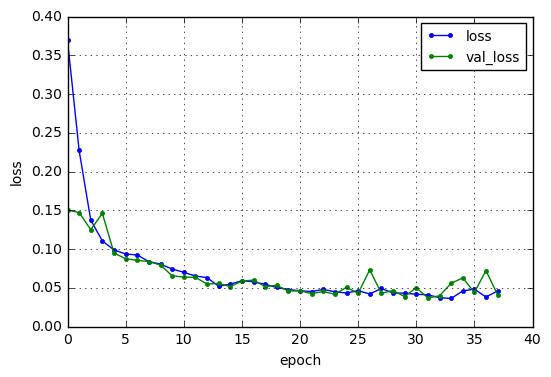

hiden node = 16
_dim=0016_Win=2048_Sld=0512_RMSprop
Train on 526 samples, validate on 526 samples
Epoch 1/50
0s - loss: 0.5484 - val_loss: 0.3422
Epoch 2/50
0s - loss: 0.2544 - val_loss: 0.1652
Epoch 3/50
0s - loss: 0.1279 - val_loss: 0.0908
Epoch 4/50
0s - loss: 0.0741 - val_loss: 0.0621
Epoch 5/50
0s - loss: 0.0735 - val_loss: 0.0579
Epoch 6/50
0s - loss: 0.0603 - val_loss: 0.0668
Epoch 7/50
0s - loss: 0.0542 - val_loss: 0.0520
Epoch 8/50
0s - loss: 0.0657 - val_loss: 0.0523
Epoch 9/50
0s - loss: 0.0519 - val_loss: 0.0643
Epoch 10/50
0s - loss: 0.0520 - val_loss: 0.0538
Epoch 11/50
0s - loss: 0.0586 - val_loss: 0.0491
Epoch 12/50
0s - loss: 0.0505 - val_loss: 0.0373
Epoch 13/50
0s - loss: 0.0568 - val_loss: 0.0393
Epoch 14/50
0s - loss: 0.0456 - val_loss: 0.0640
Epoch 15/50
0s - loss: 0.0551 - val_loss: 0.0496
Epoch 16/50
0s - loss: 0.0475 - val_loss: 0.0373
Epoch 17/50
0s - loss: 0.0501 - val_loss: 0.0403
Epoch 18/50
0s - loss: 0.0535 - val_loss: 0.0852
Epoch 19/50
0s - loss: 0.0496

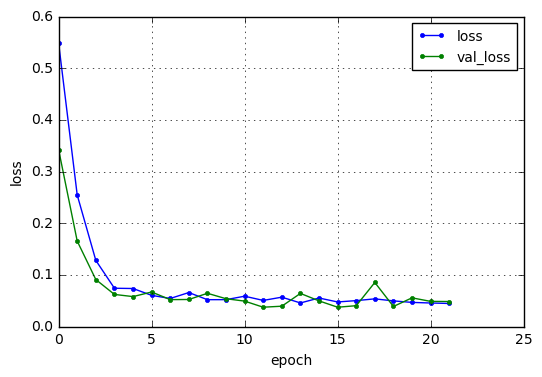

hiden node = 16
_dim=0016_Win=2048_Sld=0512_Nadam
Train on 526 samples, validate on 526 samples
Epoch 1/50
0s - loss: 0.5275 - val_loss: 0.2720
Epoch 2/50
0s - loss: 0.1764 - val_loss: 0.1047
Epoch 3/50
0s - loss: 0.1071 - val_loss: 0.0936
Epoch 4/50
0s - loss: 0.1193 - val_loss: 0.1845
Epoch 5/50
0s - loss: 0.1260 - val_loss: 0.0967
Epoch 6/50
0s - loss: 0.1164 - val_loss: 0.0978
Epoch 7/50
0s - loss: 0.1031 - val_loss: 0.1117
Epoch 8/50
0s - loss: 0.1013 - val_loss: 0.0926
Epoch 9/50
0s - loss: 0.0970 - val_loss: 0.0941
Epoch 10/50
0s - loss: 0.0961 - val_loss: 0.0968
Epoch 11/50
0s - loss: 0.1107 - val_loss: 0.0976
Epoch 12/50
0s - loss: 0.1027 - val_loss: 0.1101
Epoch 13/50
0s - loss: 0.1021 - val_loss: 0.0990
Epoch 14/50
0s - loss: 0.0992 - val_loss: 0.0989
 32/526 [>.............................] - ETA: 0s

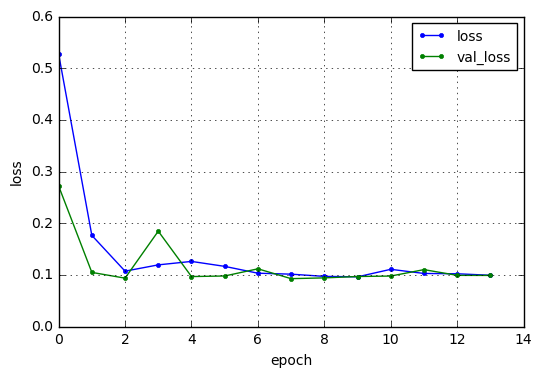

 72%|███████▏  | 188/262 [00:00<00:00, 1856.17it/s]

AccX is registed now
Build Complete
Source shape is(1077870,)
window frames num =524
offset=622


100%|██████████| 262/262 [00:00<00:00, 1213.50it/s]


hiden node = 16
_dim=0016_Win=4096_Sld=1024_SGD
Train on 263 samples, validate on 263 samples
Epoch 1/50
0s - loss: 0.7522 - val_loss: 0.7516
Epoch 2/50
0s - loss: 0.7513 - val_loss: 0.7507
Epoch 3/50
0s - loss: 0.7504 - val_loss: 0.7499
Epoch 4/50
0s - loss: 0.7496 - val_loss: 0.7492
Epoch 5/50
0s - loss: 0.7489 - val_loss: 0.7485
Epoch 6/50
0s - loss: 0.7483 - val_loss: 0.7479
Epoch 7/50
0s - loss: 0.7476 - val_loss: 0.7472
Epoch 8/50
0s - loss: 0.7469 - val_loss: 0.7465
Epoch 9/50
0s - loss: 0.7463 - val_loss: 0.7459
Epoch 10/50
0s - loss: 0.7456 - val_loss: 0.7452
Epoch 11/50
0s - loss: 0.7450 - val_loss: 0.7446
Epoch 12/50
0s - loss: 0.7443 - val_loss: 0.7439
Epoch 13/50
0s - loss: 0.7437 - val_loss: 0.7433
Epoch 14/50
0s - loss: 0.7431 - val_loss: 0.7427
Epoch 15/50
0s - loss: 0.7424 - val_loss: 0.7421
Epoch 16/50
0s - loss: 0.7418 - val_loss: 0.7415
Epoch 17/50
0s - loss: 0.7412 - val_loss: 0.7409
Epoch 18/50
0s - loss: 0.7406 - val_loss: 0.7403
Epoch 19/50
0s - loss: 0.7400 - v

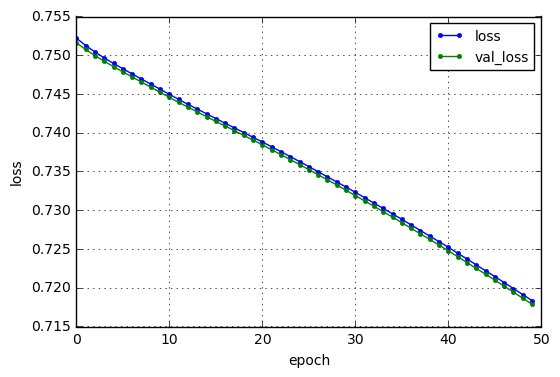

hiden node = 16
_dim=0016_Win=4096_Sld=1024_Adadelta
Train on 263 samples, validate on 263 samples
Epoch 1/50
0s - loss: 0.7303 - val_loss: 0.6916
Epoch 2/50
0s - loss: 0.6638 - val_loss: 0.6236
Epoch 3/50
0s - loss: 0.5983 - val_loss: 0.5613
Epoch 4/50
0s - loss: 0.5387 - val_loss: 0.5058
Epoch 5/50
0s - loss: 0.4857 - val_loss: 0.4564
Epoch 6/50
0s - loss: 0.4385 - val_loss: 0.4131
Epoch 7/50
0s - loss: 0.3972 - val_loss: 0.3736
Epoch 8/50
0s - loss: 0.3595 - val_loss: 0.3393
Epoch 9/50
0s - loss: 0.3267 - val_loss: 0.3088
Epoch 10/50
0s - loss: 0.2977 - val_loss: 0.2821
Epoch 11/50
0s - loss: 0.2721 - val_loss: 0.2580
Epoch 12/50
0s - loss: 0.2491 - val_loss: 0.2364
Epoch 13/50
0s - loss: 0.2285 - val_loss: 0.2173
Epoch 14/50
0s - loss: 0.2102 - val_loss: 0.1999
Epoch 15/50
0s - loss: 0.1935 - val_loss: 0.1845
Epoch 16/50
0s - loss: 0.1788 - val_loss: 0.1704
Epoch 17/50
0s - loss: 0.1653 - val_loss: 0.1582
Epoch 18/50
0s - loss: 0.1534 - val_loss: 0.1468
Epoch 19/50
0s - loss: 0.142

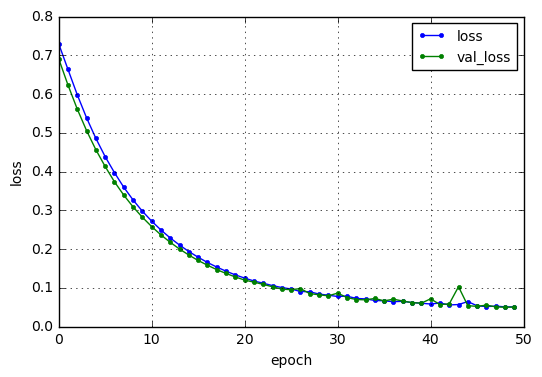

hiden node = 16
_dim=0016_Win=4096_Sld=1024_Adamax
Train on 263 samples, validate on 263 samples
Epoch 1/50
0s - loss: 0.6929 - val_loss: 0.5340
Epoch 2/50
0s - loss: 0.4359 - val_loss: 0.3111
Epoch 3/50
0s - loss: 0.2560 - val_loss: 0.1863
Epoch 4/50
0s - loss: 0.1601 - val_loss: 0.1309
Epoch 5/50
0s - loss: 0.1193 - val_loss: 0.1054
Epoch 6/50
0s - loss: 0.0987 - val_loss: 0.0917
Epoch 7/50
0s - loss: 0.0886 - val_loss: 0.0816
Epoch 8/50
0s - loss: 0.0808 - val_loss: 0.0778
Epoch 9/50
0s - loss: 0.0770 - val_loss: 0.0740
Epoch 10/50
0s - loss: 0.0721 - val_loss: 0.0688
Epoch 11/50
0s - loss: 0.0670 - val_loss: 0.0648
Epoch 12/50
0s - loss: 0.0636 - val_loss: 0.0608
Epoch 13/50
0s - loss: 0.0608 - val_loss: 0.0578
Epoch 14/50
0s - loss: 0.0572 - val_loss: 0.0548
Epoch 15/50
0s - loss: 0.0548 - val_loss: 0.0521
Epoch 16/50
0s - loss: 0.0522 - val_loss: 0.0500
Epoch 17/50
0s - loss: 0.0495 - val_loss: 0.0486
Epoch 18/50
0s - loss: 0.0492 - val_loss: 0.0510
Epoch 19/50
0s - loss: 0.0476 

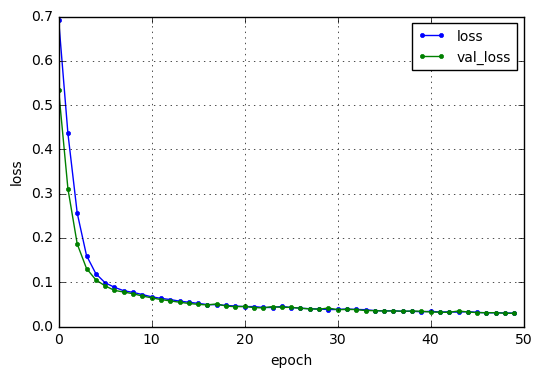

hiden node = 16
_dim=0016_Win=4096_Sld=1024_Adam
Train on 263 samples, validate on 263 samples
Epoch 1/50
0s - loss: 0.7024 - val_loss: 0.5923
Epoch 2/50
0s - loss: 0.5175 - val_loss: 0.4153
Epoch 3/50
0s - loss: 0.3587 - val_loss: 0.2826
Epoch 4/50
0s - loss: 0.2444 - val_loss: 0.1947
Epoch 5/50
0s - loss: 0.1714 - val_loss: 0.1398
Epoch 6/50
0s - loss: 0.1259 - val_loss: 0.1082
Epoch 7/50
0s - loss: 0.1010 - val_loss: 0.0953
Epoch 8/50
0s - loss: 0.0927 - val_loss: 0.0892
Epoch 9/50
0s - loss: 0.0868 - val_loss: 0.0851
Epoch 10/50
0s - loss: 0.0845 - val_loss: 0.0798
Epoch 11/50
0s - loss: 0.0813 - val_loss: 0.0910
Epoch 12/50
0s - loss: 0.0900 - val_loss: 0.0827
Epoch 13/50
0s - loss: 0.0817 - val_loss: 0.0746
Epoch 14/50
0s - loss: 0.0737 - val_loss: 0.0713
Epoch 15/50
0s - loss: 0.0687 - val_loss: 0.0699
Epoch 16/50
0s - loss: 0.0670 - val_loss: 0.0654
Epoch 17/50
0s - loss: 0.0634 - val_loss: 0.0618
Epoch 18/50
0s - loss: 0.0633 - val_loss: 0.0622
Epoch 19/50
0s - loss: 0.0640 - 

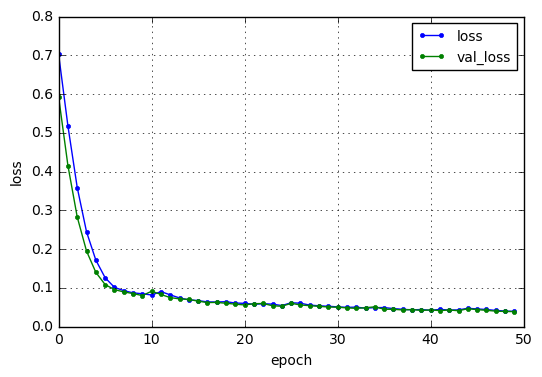

hiden node = 16
_dim=0016_Win=4096_Sld=1024_Adagrad
Train on 263 samples, validate on 263 samples
Epoch 1/50
0s - loss: 0.5064 - val_loss: 0.2040
Epoch 2/50
0s - loss: 0.1594 - val_loss: 0.1204
Epoch 3/50
0s - loss: 0.1132 - val_loss: 0.1217
Epoch 4/50
0s - loss: 0.1137 - val_loss: 0.1064
Epoch 5/50
0s - loss: 0.1092 - val_loss: 0.1226
Epoch 6/50
0s - loss: 0.1152 - val_loss: 0.1305
Epoch 7/50
0s - loss: 0.1185 - val_loss: 0.1087
Epoch 8/50
0s - loss: 0.1065 - val_loss: 0.1043
Epoch 9/50
0s - loss: 0.1037 - val_loss: 0.1028
Epoch 10/50
0s - loss: 0.1028 - val_loss: 0.1019
Epoch 11/50
0s - loss: 0.1201 - val_loss: 0.1131
Epoch 12/50
0s - loss: 0.1274 - val_loss: 0.1184
Epoch 13/50
0s - loss: 0.1125 - val_loss: 0.1058
Epoch 14/50
0s - loss: 0.1046 - val_loss: 0.1027
Epoch 15/50
0s - loss: 0.1167 - val_loss: 0.1141
Epoch 16/50
0s - loss: 0.1272 - val_loss: 0.1336
 32/263 [==>...........................] - ETA: 0s

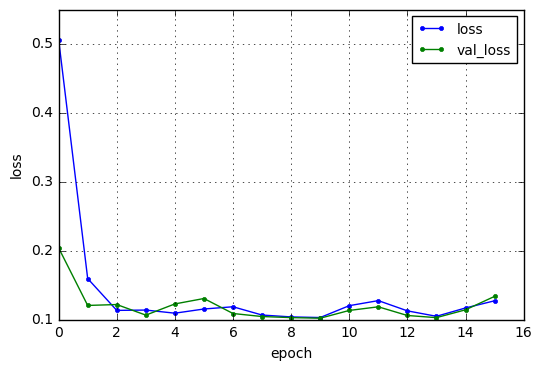

hiden node = 16
_dim=0016_Win=4096_Sld=1024_RMSprop
Train on 263 samples, validate on 263 samples
Epoch 1/50
0s - loss: 0.6721 - val_loss: 0.4926
Epoch 2/50
0s - loss: 0.4212 - val_loss: 0.4463
Epoch 3/50
0s - loss: 0.3042 - val_loss: 0.2298
Epoch 4/50
0s - loss: 0.2187 - val_loss: 0.2418
Epoch 5/50
0s - loss: 0.1923 - val_loss: 0.1676
Epoch 6/50
0s - loss: 0.1489 - val_loss: 0.2206
Epoch 7/50
0s - loss: 0.1513 - val_loss: 0.1080
Epoch 8/50
0s - loss: 0.1043 - val_loss: 0.1208
Epoch 9/50
0s - loss: 0.1088 - val_loss: 0.0869
Epoch 10/50
0s - loss: 0.0902 - val_loss: 0.0844
Epoch 11/50
0s - loss: 0.0829 - val_loss: 0.1021
Epoch 12/50
0s - loss: 0.0880 - val_loss: 0.0804
Epoch 13/50
0s - loss: 0.0824 - val_loss: 0.0711
Epoch 14/50
0s - loss: 0.0823 - val_loss: 0.0716
Epoch 15/50
0s - loss: 0.0839 - val_loss: 0.1547
Epoch 16/50
0s - loss: 0.1010 - val_loss: 0.0765
Epoch 17/50
0s - loss: 0.1046 - val_loss: 0.0868
Epoch 18/50
0s - loss: 0.0801 - val_loss: 0.0732
Epoch 19/50
0s - loss: 0.0844

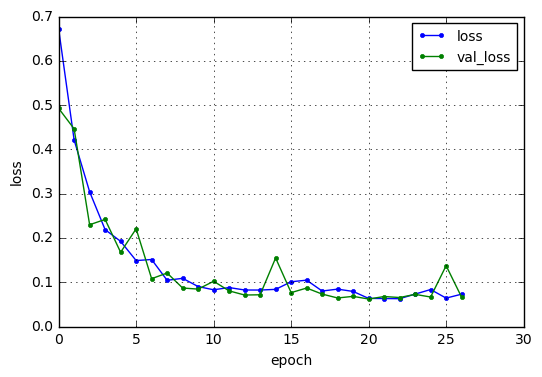

hiden node = 16
_dim=0016_Win=4096_Sld=1024_Nadam
Train on 263 samples, validate on 263 samples
Epoch 1/50
0s - loss: 0.6586 - val_loss: 0.4806
Epoch 2/50
0s - loss: 0.3915 - val_loss: 0.2972
Epoch 3/50
0s - loss: 0.2784 - val_loss: 0.1937
Epoch 4/50
0s - loss: 0.1726 - val_loss: 0.1604
Epoch 5/50
0s - loss: 0.1381 - val_loss: 0.1376
Epoch 6/50
0s - loss: 0.1116 - val_loss: 0.1028
Epoch 7/50
0s - loss: 0.1022 - val_loss: 0.1012
Epoch 8/50
0s - loss: 0.1012 - val_loss: 0.1003
Epoch 9/50
0s - loss: 0.1000 - val_loss: 0.0980
Epoch 10/50
0s - loss: 0.1060 - val_loss: 0.1132
Epoch 11/50
0s - loss: 0.1077 - val_loss: 0.1016
Epoch 12/50
0s - loss: 0.1004 - val_loss: 0.0992
Epoch 13/50
0s - loss: 0.0991 - val_loss: 0.0988
Epoch 14/50
0s - loss: 0.0987 - val_loss: 0.0982
Epoch 15/50
0s - loss: 0.0981 - val_loss: 0.0976
Epoch 16/50
0s - loss: 0.0980 - val_loss: 0.0974
Epoch 17/50
0s - loss: 0.0976 - val_loss: 0.0971
Epoch 18/50
0s - loss: 0.0969 - val_loss: 0.0956
Epoch 19/50
0s - loss: 0.0944 -

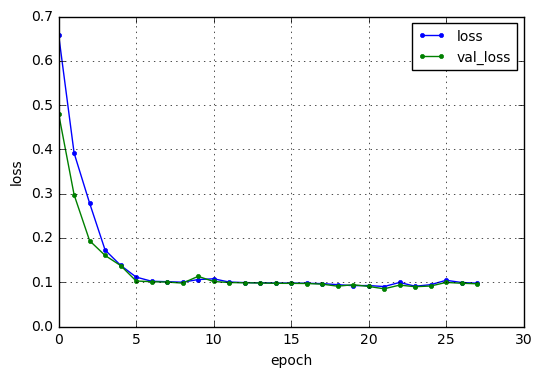

In [22]:
# loop windowWidth
for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    w=window()
    w.SetData('AccX',TrimData[0]['AccX'])
    wind=w.Compile(windowWidth=WindowNum,slidingWidth=SlidingNum)
    windoW=wind.reshape((len(wind),np.prod(wind.shape[1:])))
    
    for opt,optName in zip(optimizers,optimArray):
        print "hiden node = "+str(AEDimention)
        CommonName='_dim='+str(AEDimention).zfill(4)+'_Win='+str(WindowNum).zfill(4)+'_Sld='+str(SlidingNum).zfill(4)+'_'+optName
        print CommonName
        
        np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
        np.savez(WindowDataPath+CommonName+'_Train',data=windoW)
        
        AutoEncoder(windoW,windoW,AEDimention,optName,CommonName)

In [23]:
print 'finish'

finish


手洗いの識別にて「タイムスライス」という言葉が出た．意味としては，Native Baisian Networkにて，あるデータiについての確率を過去からのデータから導出する際にその過去がどれくらいの過去なのかを示す．つまりP($X_i$)をP($X_(i-1)$)からP($X_{i-T_n})$)から導出するとした時の$T_n$がタイムスライスである．

これは学習で言うバッチサイズと似ているのではないかと考える．今回学習は訓練データをシャッフルしてない．つまり，学習する際の訓練データの時系列は連続であると言える．

よって，件の識別はタイムスライスの値によって識別率は変化するらしい．ならば，類似していると仮定するバッチサイズの大きさによって識別結果も変わるかどうか検証する．

In [ ]:
# loop windowWidth
l=len(WindowWidth)*len(optimArray)
pbar = tqdm_notebook(total=l)
i=0
for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    w=window()
    w.SetData('AccX',TrimData[0]['AccX'])
    wind=w.Compile(windowWidth=WindowNum,slidingWidth=SlidingNum)
    windoW=wind.reshape((len(wind),np.prod(wind.shape[1:])))
    
    for bs in [1,2,4,8,16,32]:
        print "hiden node = "+str(AEDimention)
        CommonName='_dim='+str(AEDimention).zfill(4)+'_Win='+str(WindowNum).zfill(4)
        CommonName=CommonName+'_Sld='+str(SlidingNum).zfill(4)+'_'+optName
        CommonName=CommonName+'BatchSize='+str(bs).zfill(2)
        print CommonName
        
        np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
        np.savez(WindowDataPath+CommonName+'_Train',data=windoW)
        
        AutoEncoder(windoW,windoW,AEDimention,optimArray[2],CommonName,batchSize=bs)
        
        pbar.update(i+1)
pbar.close()

 15%|█▌        | 1278/8419 [00:00<00:00, 12770.66it/s]

AccX is registed now
Build Complete
Source shape is(1077870,)
window frames num =16839
offset=46


 45%|████▌     | 3825/8419 [00:00<00:01, 3460.06it/s]Exception in thread Thread-27:
Traceback (most recent call last):
  File "/home/takeyama/.pyenv/versions/2.7.11/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/takeyama/.pyenv/versions/2.7.11/envs/takeyama/src/tqdm/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/home/takeyama/.pyenv/versions/2.7.11/envs/takeyama/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

 50%|████▉     | 4185/8419 [00:00<00:01, 2558.03it/s]

100%|██████████| 8419/8419 [00:05<00:00, 1498.05it/s]


hiden node = 16
_dim=0016_Win=0128_Sld=0032_NadamBatchSize=01
Train on 8420 samples, validate on 8420 samples
Epoch 1/50
6s - loss: 0.0111 - val_loss: 0.0046
Epoch 2/50
6s - loss: 0.0042 - val_loss: 0.0033
Epoch 3/50
6s - loss: 0.0032 - val_loss: 0.0028
Epoch 4/50
6s - loss: 0.0026 - val_loss: 0.0021
Epoch 5/50
6s - loss: 0.0022 - val_loss: 0.0019
Epoch 6/50
6s - loss: 0.0019 - val_loss: 0.0017
Epoch 7/50
6s - loss: 0.0018 - val_loss: 0.0013
Epoch 8/50
6s - loss: 0.0016 - val_loss: 0.0013
Epoch 9/50
6s - loss: 0.0016 - val_loss: 0.0012
Epoch 10/50
